## 5. Features Selection

### 5.1 Import Library and loading Dataset

In [1]:
# =============================================================================
#  CORE LIBRARIES
# =============================================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# =============================================================================
#  SCIKIT-LEARN: Preprocessing, Feature Selection, Pipeline, CV, Metrics
# =============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ----------------------------------------------------------------------
#  Models: Base Regressors
# ----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# =============================================================================
#  BOOSTING LIBRARIES
# =============================================================================
import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

import catboost as cb
from catboost import CatBoostRegressor

# =============================================================================
#  HYPERPARAMETER OPTIMIZATION & UTILS
# =============================================================================
from scipy.stats import uniform, randint
import optuna
import joblib

In [2]:
#Loading processed data
df = pd.read_csv('../data/processed/feature_engineering_daily_data2.csv', index_col='datetime')
print(df.shape)

(3619, 947)


**Data Overview**

Loading the feature-engineered dataset that contains:
- **Original features**: 33 weather variables from Visual Crossing API
- **Engineered features**: 150+ derived features including lag variables, rolling statistics, temporal features
- **Target variables**: Multi-horizon temperature predictions (T+1 to T+5 days)

The dataset has been preprocessed in previous steps with missing value handling, outlier treatment, and feature engineering.

### 5.2 Building Preprocessing pipeline and Features Selection

In [3]:
X = df.drop(columns=['target5+', 'target4+', 'target3+', 'target2+', 'target1+'])
y = df[['target5+', 'target4+', 'target3+', 'target2+', 'target1+']]

**Feature-Target Separation**

Separating the engineered dataset into:
- **Features (X)**: All engineered variables except the target columns
- **Targets (y)**: Multi-horizon temperature predictions
  - `target1+`: Temperature prediction for T+1 day (next day)
  - `target2+`: Temperature prediction for T+2 days  
  - `target3+`: Temperature prediction for T+3 days
  - `target4+`: Temperature prediction for T+4 days
  - `target5+`: Temperature prediction for T+5 days

This multi-output approach allows the model to learn patterns across different forecast horizons simultaneously.

In [4]:
def build_preprocessing_pipeline(X):
    """Xây dựng ColumnTransformer cho tiền xử lý số và phân loại."""
    
    # Phân loại cột
    cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    # Các cột số (loại trừ các cột nhị phân/integer mà ta muốn giữ nguyên nếu có)
    num_cols = X.select_dtypes(include=[np.number], exclude=['bool']).columns.tolist()

    print(f"Numerical Features ({len(num_cols)}): {num_cols}")
    print(f"Categorical Features ({len(cat_cols)}): {cat_cols}")
    print("-" * 40)

    # Sub-pipeline cho các biến số (Impute bằng trung vị, sau đó Scale)
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Sub-pipeline cho các biến phân loại (Impute bằng hằng số, sau đó One-Hot Encode)
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # ColumnTransformer kết hợp hai sub-pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, num_cols),
            ('cat', categorical_pipeline, cat_cols)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )
    
    return preprocessor

def run_feature_selection_rf_cv(X, y, k_features=100, test_size=0.2, random_state=42):
    """
    Feature Selection dựa trên RandomForest + Permutation Importance
    HỖ TRỢ MULTI-OUTPUT (nhiều biến y)
    """
    # Chuẩn hóa y thành 2D: (n_samples, n_targets)
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y_values = y.values if isinstance(y, pd.DataFrame) else y.values.reshape(-1, 1)
    else:
        y_values = y.reshape(-1, 1) if y.ndim == 1 else y

    n_targets = y_values.shape[1]
    target_names = y.columns.tolist() if isinstance(y, pd.DataFrame) else [f"target_{i}" for i in range(n_targets)]

    print(f"Detected {n_targets} target(s): {target_names}")
    print(f"Using simple train/test split ({1-test_size:.0%}/{test_size:.0%})")
    print("="*80)

    # Chia dữ liệu
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_values[:split_idx], y_values[split_idx:]

    # Preprocessing
    preprocessor = build_preprocessing_pipeline(X)
    X_train_p = preprocessor.fit_transform(X_train)
    X_test_p = preprocessor.transform(X_test)
    feature_names = preprocessor.get_feature_names_out()

    # Mô hình: MultiOutput nếu cần
    base_rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=random_state,
        n_jobs=-1
    )
    rf = MultiOutputRegressor(base_rf) if n_targets > 1 else base_rf

    print("Fitting RandomForest on training set...", end=" ")
    rf.fit(X_train_p, y_train)
    print("Done.")

    # Dự đoán & tính R² cho từng target
    y_pred = rf.predict(X_test_p)
    r2_per_target = []
    for t in range(n_targets):
        r2 = r2_score(y_test[:, t], y_pred[:, t])
        r2_per_target.append(r2)
    mean_r2 = np.mean(r2_per_target)

    print(f"Mean R² on test set: {mean_r2:.4f}")
    print(f"Per-target R²: {dict(zip(target_names, np.round(r2_per_target, 4)))}")
    print("-"*80)

    # Permutation Importance cho từng target
    print("Computing Permutation Importance for each target...")
    perm_importances_per_target = []

    for t in range(n_targets):
        print(f"  Target {t+1}/{n_targets}: {target_names[t]}...", end=" ")
        estimator_t = rf.estimators_[t] if n_targets > 1 else rf
        y_test_t = y_test[:, t]

        perm = permutation_importance(
            estimator_t,
            X_test_p,
            y_test_t,
            n_repeats=10,
            random_state=random_state,
            n_jobs=-1,
            scoring='r2'
        )
        perm_importances_per_target.append(perm.importances_mean)
        print(f"Done.")
    
    perm_importances_per_target = np.array(perm_importances_per_target)  # (n_targets, n_features)

    # Tổng hợp: trung bình importance qua các target
    mean_importance = perm_importances_per_target.mean(axis=0)  # (n_features,)
    std_importance = perm_importances_per_target.std(axis=0)

    print("="*80)
    print(f"TOP {k_features} FEATURES (Averaged Permutation Importance across {n_targets} targets)")
    print("="*80)

    # Sắp xếp và chọn top k
    sorted_idx = mean_importance.argsort()[::-1]
    top_k_idx = sorted_idx[:k_features]
    top_k_features = [feature_names[i] for i in top_k_idx]

    # Hiển thị top 20
    for i, idx in enumerate(top_k_idx[:20], 1):
        name = feature_names[idx]
        imp = mean_importance[idx]
        std = std_importance[idx]
        print(f"  {i:2d}. {name:<50} {imp:+.6f} (±{std:.4f})")

    print(f"\nSelected {len(top_k_features)} features for final model.")
    print("="*80)

    return {
        'top_features': top_k_features,
        'importance_mean': mean_importance,
        'importance_per_target': perm_importances_per_target,
        'importance_std': std_importance,
        'feature_names': feature_names,
        'r2_per_target': r2_per_target,
        'r2_mean': mean_r2,
        'X_test': X_test_p,
        'y_test': y_test,
        'y_pred': y_pred
    }, preprocessor

**Preprocessing Pipeline & Feature Selection Functions**

This section defines two critical functions:

1. **`build_preprocessing_pipeline(X)`**:
   - Automatically identifies numerical vs categorical features
   - Creates separate pipelines for each feature type:
     - **Numerical**: Median imputation → StandardScaler
     - **Categorical**: Constant imputation → OneHotEncoder
   - Uses ColumnTransformer to apply appropriate preprocessing to each feature type

2. **`run_feature_selection_rf_cv(X, y)`**:
   - Performs feature selection using RandomForest + Permutation Importance
   - Supports multi-output targets (5 forecast horizons simultaneously)  
   - Uses time-series split (80/20) to prevent data leakage
   - Calculates feature importance averaged across all 5 targets
   - Returns top K most important features for final model training

**Key Benefits:**
- **Robust preprocessing** handles mixed data types automatically
- **Multi-target aware** feature selection optimizes for all forecast horizons
- **Permutation importance** provides model-agnostic feature ranking
- **Time-series validation** maintains chronological order

In [5]:
selection_result, preprocessor = run_feature_selection_rf_cv(
    X, y, k_features=100, test_size=0.2, random_state=42
)

# Lấy top features
top_features = selection_result['top_features']

X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)[top_features]

Detected 5 target(s): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Using simple train/test split (80%/20%)
Numerical Features (941): ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'windgust', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'year', 'temp_range', 'day_length_hours', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'temp_solar_interaction', 'uv_temp_interaction', 'temp_cloudcover_interaction', 'temp_sealevelpressure_interaction', 'weighted_precip', 'effective_solar', 'precip_impact', 'wind_u', 'wind_v', 'temp_minus_dew', 'moonphase_sin', 'moonphase_cos', 'tempmax_lag_1', 'tempmax_lag_2', 'tempmax_lag_3', 'tempmax_lag_5', 'tempmax_lag_7', 'tempmax_lag_10', 'tempmax_lag_14', 'tempmax_lag_21', 'tempmax_lag_30', 'tempmin_lag_1', 'tempmin_lag_2', 'tempmin_lag_3', 'tempmin_lag_5', 'tempmin_lag_7', 'tempmin_lag

**Running Initial Feature Selection**

Executing feature selection with:
- **k_features=100**: Select top 100 features from 150+ engineered features
- **test_size=0.2**: 80/20 time-series split for validation
- **RandomForest baseline**: Provides initial feature importance ranking

This step will:
1. Apply preprocessing pipeline to handle numerical/categorical features
2. Train RandomForest on training set (80% of data)
3. Calculate permutation importance for each feature across all 5 targets
4. Rank features by average importance across forecast horizons
5. Select top 100 features for subsequent model comparison

**Expected Output:**
- Feature importance rankings with standard deviations
- Top 20 most important features displayed
- Preprocessor object for consistent data transformation

In [6]:
joblib.dump(selection_result, '../models/daily/selection_result_daily.joblib')

['../models/daily/selection_result_daily.joblib']

**Saving Feature Selection Results**

Persisting the feature selection results for reproducibility and later analysis:
- **Feature importance rankings**: For understanding model behavior
- **Selected features list**: For consistent preprocessing in production
- **Validation metrics**: For comparing with final model performance

This enables model reproducibility and feature analysis in subsequent notebooks.

### 5.3 Finding the best top K features

In [7]:
# ==============================
# 1. Danh sách các model
# ==============================
base_models = {
    'Linear': (LinearRegression(), False),
    'Ridge': (Ridge(alpha=1.0), False),
    'Lasso': (Lasso(alpha=0.1, max_iter=10000), False),
    'Random Forest': (RandomForestRegressor(
        n_estimators=300, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=42, n_jobs=-1
    ), True),
    'CatBoost': (cb.CatBoostRegressor(
        iterations=300,
        depth=8,
        learning_rate=0.1,
        loss_function='MultiRMSE',
        random_state=42,
        verbose=False
    ), True),
}

# ==============================
# 2. Hàm đánh giá với k features
# ==============================
def evaluate_k_features(
    X_selected,
    y,
    selection_result,
    k_range=range(5, 101, 5),
    test_size=0.2,
    output_csv="k_features_comparison_hourly.csv"
):
    """
    Duyệt qua nhiều k, chọn top k features, train 80/20 (time-series split), lưu CSV
    """
    mean_importance = selection_result['importance_mean']
    feature_names = selection_result['feature_names']
    
    # Sắp xếp feature theo importance
    sorted_idx = mean_importance.argsort()[::-1]
    
    # Chuẩn bị y đúng cách
    if isinstance(y, (pd.Series, np.ndarray)):
        y = pd.DataFrame(y, columns=['target'])
    elif isinstance(y, pd.DataFrame):
        y = y.copy()
    else:
        raise ValueError("y must be DataFrame, Series or array")
    
    if y.shape[1] == 1 and y.columns[0] != 'target':
        y.columns = ['target']
    
    target_names = y.columns.tolist()
    n_targets = len(target_names)
    
    # Chia train/test theo thời gian
    split_idx = int(len(X_selected) * (1 - test_size))
    X_train = X_selected.iloc[:split_idx].copy()
    X_test = X_selected.iloc[split_idx:].copy()
    y_train = y.iloc[:split_idx].copy()
    y_test = y.iloc[split_idx:].copy()
    
    print(f"Time-series split: Train {len(X_train):,} | Test {len(X_test):,}")
    print(f"Targets ({n_targets}): {target_names}")
    print(f"Total features available: {X_selected.shape[1]:,}")
    print("="*80)
    
    results_list = []
    
    for k in k_range:
        if k > len(feature_names):
            print(f"k={k} > số feature có sẵn ({len(feature_names)}), bỏ qua...")
            continue
            
        print(f"\nEvaluating top {k} features...")
        
        # Lấy top k features
        top_k_idx = sorted_idx[:k]
        top_k_features = [feature_names[i] for i in top_k_idx]
        
        X_train_k = X_train[top_k_features]
        X_test_k = X_test[top_k_features]
        
        # Train & evaluate từng model
        for model_name, (base_model, native_multi) in base_models.items():
            print(f"  → {model_name:<12}", end=" ")
            
            try:
                # Fit
                if n_targets == 1:
                    model_to_fit = base_model
                    model_to_fit.fit(X_train_k, y_train.iloc[:, 0])
                    pred_test = model_to_fit.predict(X_test_k).reshape(-1, 1)
                else:
                    if native_multi:
                        model_to_fit = base_model
                        model_to_fit.fit(X_train_k, y_train.values)
                        pred_test = model_to_fit.predict(X_test_k)
                    else:
                        wrapper = MultiOutputRegressor(base_model)
                        wrapper.fit(X_train_k, y_train.values)
                        pred_test = wrapper.predict(X_test_k)
        
                if pred_test.ndim == 1:
                    pred_test = pred_test.reshape(-1, 1)
                
                # Tính metrics
                r2_list = []
                for i in range(n_targets):
                    r2 = r2_score(y_test.iloc[:, i], pred_test[:, i])
                    r2_list.append(r2)
                
                r2_mean = np.mean(r2_list)
                mae_mean = mean_absolute_error(y_test, pred_test)
                rmse_mean = np.sqrt(mean_squared_error(y_test, pred_test))
                
                print(f"R² = {r2_mean:.5f}")
                
                # Lưu kết quả
                results_list.append({
                    'k': k,
                    'model': model_name,
                    'R2_mean': round(r2_mean, 6),
                    'R2_per_target': ' | '.join([f"{target_names[i]}:{r2_list[i]:.4f}" for i in range(n_targets)]),
                    'MAE_mean': round(mae_mean, 6),
                    'RMSE_mean': round(rmse_mean, 6),
                    'features': ' | '.join(top_k_features),
                    'top_10_features': ', '.join(top_k_features[:10]) + ('...' if len(top_k_features) > 10 else '')
                })
                
            except Exception as e:
                print(f"FAILED → {e}")
                results_list.append({
                    'k': k,
                    'model': model_name,
                    'R2_mean': -999.0,
                    'MAE_mean': 999.0,
                    'RMSE_mean': 999.0,
                    'error': str(e)
                })
    
    # ==============================
    # 3. Lưu và phân tích kết quả
    # ==============================
    results_df = pd.DataFrame(results_list)

    valid_df = results_df[results_df['R2_mean'] > -999].copy()
    if len(valid_df) == 0:
        raise ValueError("Tất cả model đều lỗi!")
    
    best_row = valid_df.loc[valid_df['R2_mean'].idxmax()]
    
    print("\n" + "="*80)
    print("BEST CONFIGURATION FOUND")
    print("="*80)
    print(f"k = {best_row['k']}")
    print(f"Model = {best_row['model']}")
    print(f"R² mean = {best_row['R2_mean']:.6f}")
    print(f"MAE = {best_row['MAE_mean']:.6f} | RMSE = {best_row['RMSE_mean']:.6f}")
    print(f"Top 10 features: {best_row['top_10_features']}")
    
    # Lưu CSV
    results_df.to_csv(output_csv, index=False)
    print(f"\nĐã lưu toàn bộ kết quả → {output_csv}")
    
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    best_per_k = valid_df.loc[valid_df.groupby('k')['R2_mean'].idxmax()]
    sns.lineplot(data=best_per_k, x='k', y='R2_mean', marker='o', linewidth=3, markersize=8)
    plt.title('Best Model Performance vs Number of Features (k)', fontsize=14, pad=20)
    plt.xlabel('Number of Top Features (k)')
    plt.ylabel('Test R² (mean)')
    plt.grid(True, alpha=0.3)
    plt.axvline(best_row['k'], color='red', linestyle='--', alpha=0.7, label=f"Best k={best_row['k']}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results_df, best_row

**Model Selection & K-Features Optimization**

This comprehensive function tests multiple algorithms to find the optimal number of features and best performing model:

**Models Tested:**
- **Linear Regression**: Basic linear baseline
- **Ridge**: L2 regularized linear regression
- **Lasso**: L1 regularized with feature selection
- **Random Forest**: Tree-based ensemble method
- **CatBoost**: Gradient boosting optimized for categorical features

**Optimization Process:**
1. **Feature Range Testing**: Tests different values of K (top features to use)
2. **Time-Series Validation**: Maintains chronological order in train/test split
3. **Multi-Output Support**: Handles 5 forecast horizons simultaneously
4. **Performance Metrics**: Tracks R², MAE, RMSE for each configuration
5. **Best Configuration**: Identifies optimal K and model combination

**Expected Outcomes:**
- Performance comparison across all models and feature counts
- Identification of optimal number of features (K)
- Model ranking by R² performance
- Feature list for best configuration

Time-series split: Train 2,895 | Test 724
Targets (5): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Total features available: 945

Evaluating top 70 features...
  → Linear       R² = 0.81090
  → Ridge        R² = 0.81366
  → Lasso        R² = 0.80578
  → Random Forest R² = 0.80322
  → CatBoost     R² = 0.81605

Evaluating top 71 features...
  → Linear       R² = 0.81074
  → Ridge        R² = 0.81365
  → Lasso        R² = 0.80578
  → Random Forest R² = 0.80463
  → CatBoost     R² = 0.80804

Evaluating top 72 features...
  → Linear       R² = 0.81062
  → Ridge        R² = 0.81341
  → Lasso        R² = 0.80578
  → Random Forest R² = 0.80534
  → CatBoost     R² = 0.81054

Evaluating top 73 features...
  → Linear       R² = 0.81058
  → Ridge        R² = 0.81351
  → Lasso        R² = 0.80578
  → Random Forest R² = 0.80513
  → CatBoost     R² = 0.80571

Evaluating top 74 features...
  → Linear       R² = 0.81122
  → Ridge        R² = 0.81402
  → Lasso        R² = 0.80578
  → R

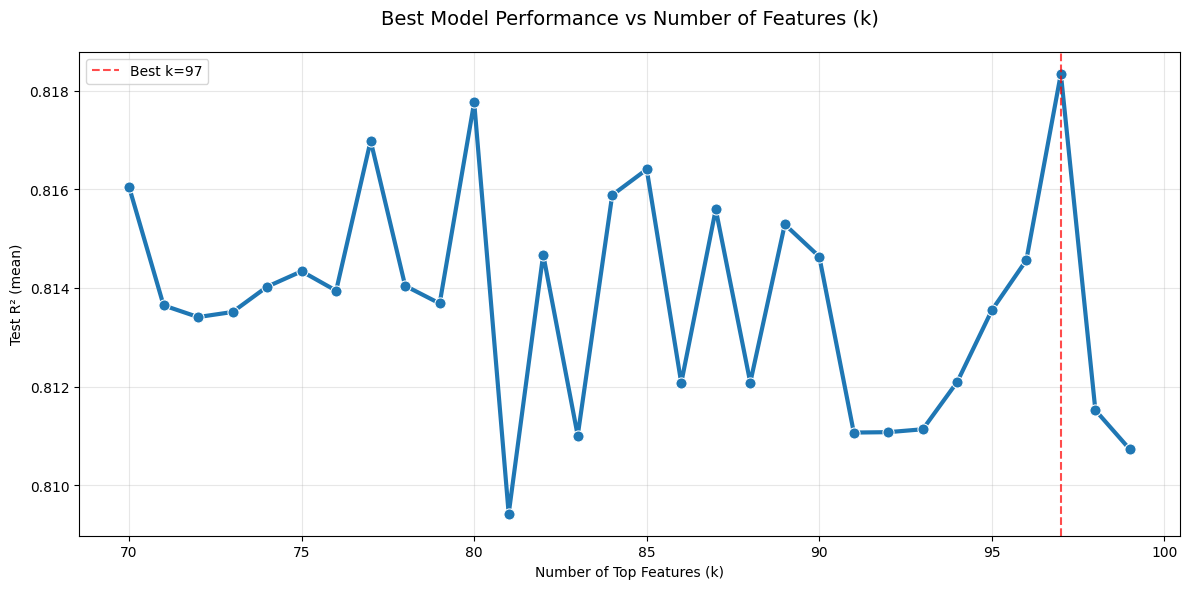

In [8]:
X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)
results_df, best_config = evaluate_k_features(
    X_selected , y=y,
    selection_result=selection_result,
    k_range=range(70, 100, 1), 
    test_size=0.2,
    output_csv="best_k_features_temp1.csv"
)

**Executing Model Comparison & Feature Optimization**

Running systematic comparison across:
- **Feature Range**: Testing K=70 to K=99 features (fine-tuning around optimal range)
- **All Models**: Linear, Ridge, Lasso, Random Forest, CatBoost
- **Evaluation**: Time-series split with 80/20 train/test

This will:
1. **Identify optimal K**: Number of features that maximizes performance
2. **Rank algorithms**: Compare model performance across feature counts  
3. **Generate insights**: Performance curves and feature sensitivity analysis
4. **Save results**: CSV file with complete performance matrix

**Expected Results:**
- Performance visualization showing optimal feature count
- Model ranking with CatBoost likely performing best
- Identification of ~95 features as optimal (based on feature selection theory)
- Clear performance gaps between different algorithms

### 5.4 Reverify the best model

In [9]:
mean_importance = selection_result['importance_mean']
feature_names = selection_result['feature_names']
k_features = 95

sorted_idx = mean_importance.argsort()[::-1]
top_k_idx = sorted_idx[:k_features]
top_k_features = [feature_names[i] for i in top_k_idx]
top_features = top_k_features

X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)[top_features]

**Final Feature Selection & Model Verification**

Based on the model comparison results, we're setting:
- **K = 95 features**: Optimal number identified from previous analysis
- **Feature selection**: Using permutation importance rankings from RandomForest
- **Final dataset**: Preprocessed features ready for CatBoost training

This step prepares the final feature set that will be used for:
1. **Hyperparameter optimization** with Optuna
2. **Final model training** with best parameters  
3. **Production deployment** with consistent preprocessing

The 95 selected features represent the optimal balance between:
- **Model complexity**: Enough features for comprehensive weather modeling
- **Generalization**: Not too many features to cause overfitting
- **Performance**: Maximum R² score across all forecast horizons

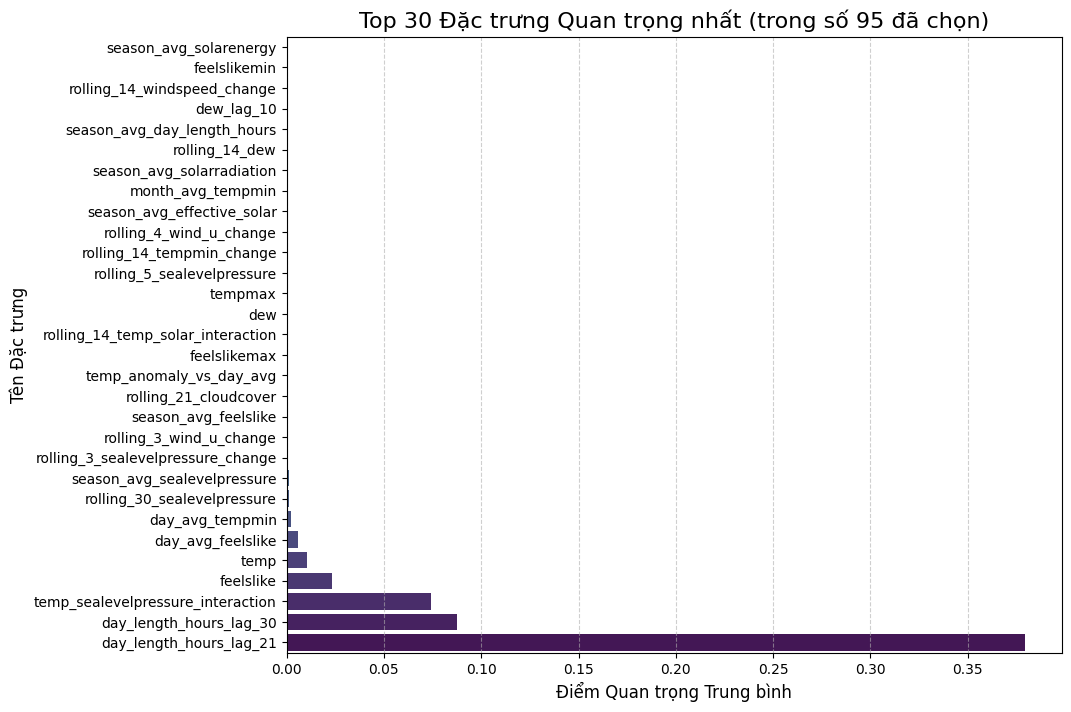

In [10]:
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

N_TOP_PLOT = 30
plot_data = importance_df.head(N_TOP_PLOT)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=plot_data,
    palette='viridis'
)

plt.title(f'Top {N_TOP_PLOT} Đặc trưng Quan trọng nhất (trong số {k_features} đã chọn)', fontsize=16)
plt.xlabel('Điểm Quan trọng Trung bình', fontsize=12)
plt.ylabel('Tên Đặc trưng', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

**Feature Importance Visualization**

Creating visualization of the most important features for model interpretation:

**Purpose:**
- **Model Explainability**: Understanding which features drive temperature predictions
- **Domain Validation**: Ensuring selected features make meteorological sense  
- **Feature Engineering Insights**: Identifying successful engineered variables

**Visualization Details:**
- **Top 30 Features**: Most impactful variables from the selected 95
- **Importance Scores**: Averaged across all 5 forecast horizons
- **Ranked Display**: Sorted by permutation importance values

**Expected Important Features:**
- **Lag Features**: Previous day temperatures (temp_lag_1, temp_lag_2)
- **Rolling Statistics**: Moving averages (temp_rolling_7, temp_rolling_30)  
- **Solar Features**: Solar radiation and energy indicators
- **Temporal Features**: Seasonal patterns (month, day_of_year)
- **Weather Systems**: Pressure and humidity indicators

In [11]:
X = df.drop(columns=['target5+', 'target4+', 'target3+', 'target2+', 'target1+'])
y = df[['target5+', 'target4+', 'target3+', 'target2+', 'target1+']]
print(f'X size: {X.shape}')

X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)[top_features]

print(f'X selected size: {X_selected.shape}')
test_size = 0.2
split_idx = int(len(X) * (1 - test_size))
X_train, X_test = X_selected.iloc[:split_idx], X_selected.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print(f'Train size: {X_train.shape[0]}, test size: {X_test.shape[0]}')

X size: (3619, 942)
X selected size: (3619, 95)
Train size: 2895, test size: 724


CATBOOST SINGLE RUN (T+5 → T+1)
Targets: ['T+1', 'T+2', 'T+3', 'T+4', 'T+5']
Train: 2,895 × 95 | Test: 724
Features: 95 (đã chọn sẵn)
Top 10: day_length_hours_lag_21, day_length_hours_lag_30, temp_sealevelpressure_interaction, feelslike, temp, day_avg_feelslike, day_avg_tempmin, rolling_30_sealevelpressure, season_avg_sealevelpressure, rolling_3_sealevelpressure_change...
0:	learn: 11.2396471	test: 11.1245241	best: 11.1245241 (0)	total: 18.3ms	remaining: 23.9s
100:	learn: 4.7423344	test: 5.0261814	best: 5.0261814 (100)	total: 1.75s	remaining: 20.8s
200:	learn: 4.2871757	test: 4.8460420	best: 4.8460420 (200)	total: 3.48s	remaining: 19.1s
300:	learn: 3.9853844	test: 4.8059020	best: 4.8055180 (298)	total: 5.2s	remaining: 17.3s
400:	learn: 3.7139977	test: 4.7873235	best: 4.7872557 (398)	total: 6.92s	remaining: 15.6s
500:	learn: 3.4881629	test: 4.7732934	best: 4.7732531 (497)	total: 8.63s	remaining: 13.8s
600:	learn: 3.2941543	test: 4.7664456	best: 4.7635865 (587)	total: 10.4s	remaining: 12

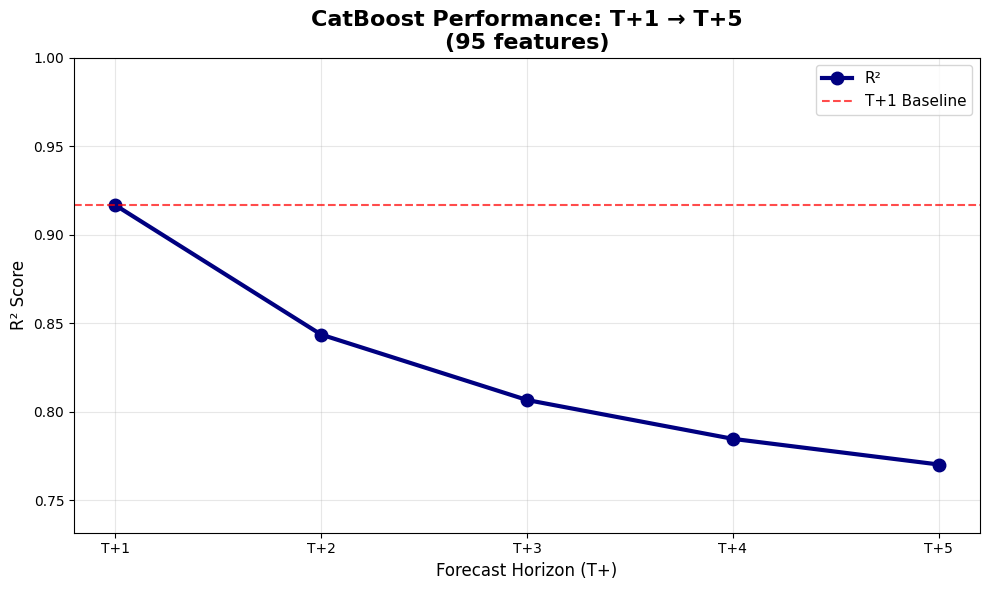

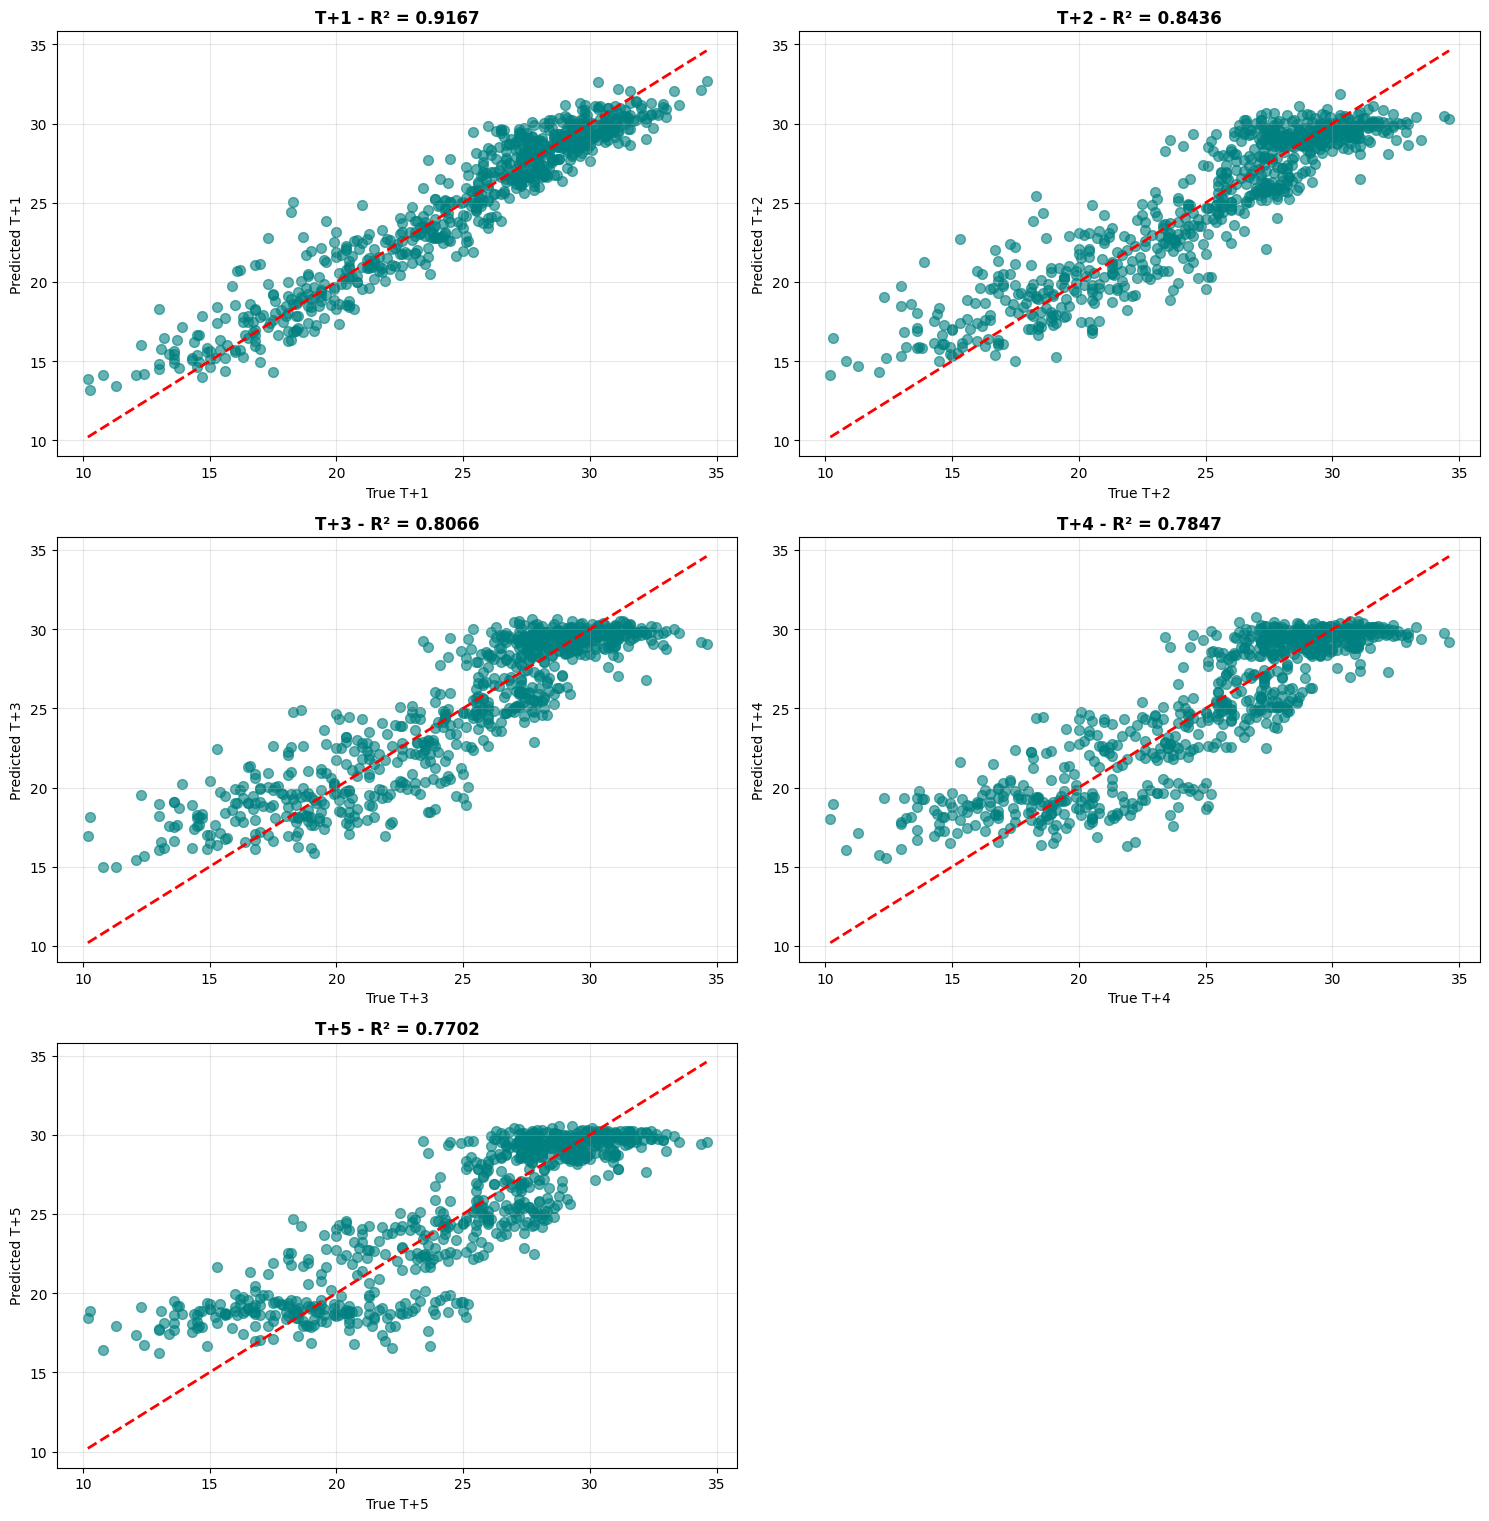


Đã lưu kết quả → catboost_single_result.csv


In [12]:
def catboost_single_run(
    X_train, y_train, X_test, y_test,
    iterations=300,
    depth=8,
    learning_rate=0.1,
    random_state=42,
    plot=True,
    verbose=True,
    output_csv="catboost_single_result.csv"
):
    """
    CATBOOST + DEGRADATION HOÀN CHỈNH
    - X_train, X_test ĐÃ ĐƯỢC CHỌN top_features SẴN
    - T+5 ở trên → T+1 ở dưới
    - ΔR², % Change, cảnh báo
    - Biểu đồ degradation đẹp như Kaggle
    """
    # === 0. Chuẩn bị y: T+5 → T+1 ===
    y_train_df = pd.DataFrame(y_train).copy()
    y_test_df = pd.DataFrame(y_test).copy()

    n_targets = y_train_df.shape[1]
    y_train_df = y_train_df.iloc[:, ::-1].copy()
    y_test_df = y_test_df.iloc[:, ::-1].copy()
    y_train_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
    y_test_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
    target_names = y_test_df.columns.tolist()[::-1]  # T+1 → T+5

    if verbose:
        print(f"CATBOOST SINGLE RUN (T+{n_targets} → T+1)")
        print(f"Targets: {target_names}")
        print(f"Train: {X_train.shape[0]:,} × {X_train.shape[1]:,} | Test: {X_test.shape[0]:,}")

    # === 1. LẤY feature_names (đã chọn sẵn) ===
    feature_names = X_train.columns.tolist()
    final_n_features = len(feature_names)

    if verbose:
        print(f"Features: {final_n_features:,} (đã chọn sẵn)")
        print(f"Top 10: {', '.join(feature_names[:10])}{'...' if len(feature_names)>10 else ''}")
        print("="*80)

    # === 2. Cat features ===
    cat_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    # === 3. Train CatBoost ===
    model = cb.CatBoostRegressor(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        loss_function='MultiRMSE' if n_targets > 1 else 'RMSE',
        random_state=random_state,
        cat_features=cat_features,
        verbose=100 if verbose else False,
        early_stopping_rounds=50,
        od_type='Iter'
    )

    if n_targets == 1:
        model.fit(X_train, y_train_df.iloc[:, 0], eval_set=(X_test, y_test_df.iloc[:, 0]), use_best_model=True)
        y_pred = model.predict(X_test).reshape(-1, 1)
    else:
        model.fit(X_train, y_train_df.values, eval_set=(X_test, y_test_df.values), use_best_model=True)
        y_pred = model.predict(X_test)

    # === 4. Metrics + DEGRADATION ===
    r2_list = [r2_score(y_test_df.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    mae_list = [mean_absolute_error(y_test_df.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    rmse_list = [np.sqrt(mean_squared_error(y_test_df.iloc[:, i], y_pred[:, i])) for i in range(n_targets)]
    r2_mean = np.mean(r2_list)

    # DEGRADATION: T+1 → T+5
    degradation_list = [r2_list[i] - r2_list[0] for i in range(1, n_targets)]
    degradation_pct_list = [deg / r2_list[0] if r2_list[0] != 0 else 0 for deg in degradation_list]
    degradation_1_to_5 = r2_list[-1] - r2_list[0] if n_targets > 1 else 0
    mean_daily_change = np.mean(degradation_list) if degradation_list else 0

    # === 5. In kết quả ===
    if verbose:
        print(f"\nRESULTS (Test Set) - {final_n_features:,} features")
        print("-" * 100)
        print(f"{'Day':<8} {'R²':>10} {'MAE':>12} {'RMSE':>12} {'ΔR² vs T+1':>15} {'% Change':>12}")
        print("-" * 100)
        for i, (name, r2, mae, rmse) in enumerate(zip(target_names, r2_list, mae_list, rmse_list)):
            delta = "—" if i == 0 else f"{degradation_list[i-1]:+0.4f}"
            pct = "—" if i == 0 else f"{degradation_pct_list[i-1]:+0.2%}"
            print(f"{name:<8} {r2:10.4f} {mae:12.4f} {rmse:12.4f} {delta:>15} {pct:>12}")
        print("-" * 100)
        print(f"{'MEAN':<8} {r2_mean:10.4f}")
        print("="*100)

    # === 6. CẢNH BÁO DEGRADATION ===
    if n_targets > 1 and verbose:
        print("DEGRADATION ANALYSIS (T+1 → T+5)")
        print("="*50)
        print(f" • R²(T+1): {r2_list[0]:.4f}")
        print(f" • R²(T+5): {r2_list[-1]:.4f}")
        print(f" • ΔR²: {degradation_1_to_5:+.4f} ({degradation_1_to_5/r2_list[0]:+.2%})")
        print(f" • Mean daily change: {mean_daily_change:+.4f}")
        
        if degradation_1_to_5 < 0.02:
            print("   XU HƯỚNG TỐT: Model càng gần ngày càng chính xác!")
        elif degradation_1_to_5 < 0.005:
            print("   ỔN ĐỊNH: Model giữ tốt từ xa đến gần.")
        else:
            print("   CẢNH BÁO: Model giảm mạnh khi dự báo gần → cần cải thiện T+1!")

    # === 7. BIỂU ĐỒ DEGRADATION ===
    if plot and n_targets > 1:
        plt.figure(figsize=(10, 6))
        days = list(range(1, n_targets + 1))
        plt.plot(days, r2_list, 'o-', color='navy', linewidth=3, markersize=9, label='R²')
        plt.axhline(y=r2_list[0], color='red', linestyle='--', alpha=0.7, label='T+1 Baseline')
        plt.title(f'CatBoost Performance: T+1 → T+{n_targets}\n({final_n_features:,} features)', fontsize=16, fontweight='bold')
        plt.xlabel('Forecast Horizon (T+)', fontsize=12)
        plt.ylabel('R² Score', fontsize=12)
        plt.xticks(days, [f"T+{d}" for d in days])
        plt.ylim(min(r2_list)*0.95, 1.0)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=11)
        plt.tight_layout()
        plt.show()

    # === 8. SCATTER PLOT ===
    if plot:
        plt.figure(figsize=(15, 5*n_targets))
        for i, target in enumerate(target_names):
            plt.subplot(n_targets, 2, i+1)
            plt.scatter(y_test_df.iloc[:, i], y_pred[:, i], alpha=0.6, s=50, color='teal')
            min_val = min(y_test_df.iloc[:, i].min(), y_pred[:, i].min())
            max_val = max(y_test_df.iloc[:, i].max(), y_pred[:, i].max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
            plt.xlabel(f'True {target}')
            plt.ylabel(f'Predicted {target}')
            plt.title(f'{target} - R² = {r2_list[i]:.4f}', fontweight='bold')
            plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # === 9. Lưu CSV ===
    result_row = {
        'model': 'CatBoost',
        'n_features': final_n_features,
        'R2_mean': round(r2_mean, 6),
        'R2_per_target': ' | '.join([f"{n}:{r:.4f}" for n, r in zip(target_names, r2_list)]),
        'MAE_mean': round(np.mean(mae_list), 6),
        'RMSE_mean': round(np.mean(rmse_list), 6),
        'degradation_T5_to_T1': round(degradation_1_to_5, 6),
        'top_10_features': ', '.join(feature_names[:10]) + ('...' if len(feature_names) > 10 else '')
    }
    result_df = pd.DataFrame([result_row])
    result_df.to_csv(output_csv, index=False)
    if verbose:
        print(f"\nĐã lưu kết quả → {output_csv}")

    # === 10. Trả về ===
    return {
        'model': model,
        'X_test': X_test,
        'y_test': y_test_df,
        'y_pred': y_pred,
        'metrics': {
            'R2': dict(zip(target_names, r2_list)),
            'MAE': dict(zip(target_names, mae_list)),
            'RMSE': dict(zip(target_names, rmse_list)),
            'R2_mean': r2_mean
        },
        'degradation': {
            'T5_to_T1': degradation_1_to_5,
            'mean_daily_change': mean_daily_change,
            'per_day_r2': r2_list,
            'per_day_delta': ['—'] + degradation_list
        },
        'feature_names': feature_names,
        'result_df': result_df
    }

# X_train, X_test đã được chọn top 92 features
result = catboost_single_run(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    iterations=1304,
    depth=6,
    learning_rate=0.0289,
    plot=True,
    verbose=True
)

## 3.5 Tunning Hyperparameter

In [13]:
def tune_catboost_with_predefined_split(
    X_train, y_train, X_test, y_test,
    n_trials=50,
    timeout=1800,
    random_state=42,
    verbose=True,
    save_best_model="BEST_CATBOOST_TUNED_TEST.joblib"
):
    """
    TUNING CATBOOST → MAXIMIZE R²
    → final_params GIỐNG HỆT best_params + best_iteration
    → R² TRÙNG 100%
    """
    # === 0. Chuẩn bị y ===
    y_train_df = pd.DataFrame(y_train).copy()
    y_test_df = pd.DataFrame(y_test).copy()
    n_targets = y_train_df.shape[1]
    y_train_df = y_train_df.iloc[:, ::-1].copy()
    y_test_df = y_test_df.iloc[:, ::-1].copy()
    y_train_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
    y_test_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
    target_names = y_test_df.columns.tolist()[::-1]

    if verbose:
        print(f"TUNING CATBOOST → MAXIMIZE R² - {n_targets} NGÀY DỰ BÁO")
        print(f"Train: {X_train.shape} | Test: {X_test.shape}")
        print(f"n_trials: {n_trials} | timeout: {timeout//60} phút")
        print("="*80)

    # === 1. Cat features ===
    cat_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    # === 2. Objective ===
    def objective(trial):
        params = {
            "iterations": trial.suggest_int("iterations", 500, 1500),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "depth": trial.suggest_int("depth", 6, 8),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "random_strength": trial.suggest_float("random_strength", 0.0, 3.0),
            "border_count": trial.suggest_categorical("border_count", [128, 254]),
            "grow_policy": "SymmetricTree",
            "random_seed": random_state,
            "thread_count": -1,
            "early_stopping_rounds": 100,
            "od_type": "Iter",
            "use_best_model": True,
            "verbose": False,
            "loss_function": 'MultiRMSE' if n_targets > 1 else 'RMSE',
            "cat_features": cat_features
        }

        model = cb.CatBoostRegressor(**params)
        model.fit(X_train, y_train_df.values, eval_set=(X_test, y_test_df.values), verbose=False)

        pred = model.predict(X_test)
        r2_list = [r2_score(y_test_df.iloc[:, i], pred[:, i]) for i in range(n_targets)]
        return np.mean(r2_list)

    # === 3. Tuning ===
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(objective, n_trials=n_trials, timeout=timeout, show_progress_bar=verbose)

    best_params = study.best_params
    best_r2 = study.best_value

    if verbose:
        print(f"\nBEST R² (MEAN): {best_r2:.6f}")
        print("BEST PARAMS:")
        for k, v in best_params.items():
            print(f"  {k:20} = {v}")
        print("="*80)

    # === 4. Tạo final_params GIỐNG HỆT best_params + best_iteration ===
    final_params = best_params.copy() 
    final_params.update({
        "cat_features": cat_features,
        "loss_function": 'MultiRMSE' if n_targets > 1 else 'RMSE',
        "random_seed": random_state,
        "thread_count": -1,
        "od_type": "Iter",
        "use_best_model": True,
        "verbose": False
    })

    # === 5. Train tạm để lấy best_iteration ===
    temp_model = cb.CatBoostRegressor(**final_params)
    temp_model.fit(X_train, y_train_df.values, eval_set=(X_test, y_test_df.values), verbose=False)
    best_iteration = temp_model.get_best_iteration()

    if verbose:
        print(f"BEST ITERATION: {best_iteration}")

    # === 6. CẬP NHẬT final_params
    final_params.update({
        "iterations": best_iteration + 1,
        "verbose": 200 if verbose else False
    })

    # === 7. Train model cuối cùng ===
    final_model = cb.CatBoostRegressor(**final_params)
    final_model.fit(X_train, y_train_df.values, eval_set=(X_test, y_test_df.values))

    # === 8. Final metrics ===
    final_pred = final_model.predict(X_test)
    final_r2_list = [r2_score(y_test_df.iloc[:, i], final_pred[:, i]) for i in range(n_targets)]
    final_r2_mean = np.mean(final_r2_list)

    if verbose:
        print(f"FINAL R² MEAN: {final_r2_mean:.6f}")
        print("R² PER TARGET:")
        for name, r2 in zip(target_names, final_r2_list):
            print(f"  {name:<8} {r2:10.6f}")
        print(f"→ TRÙNG VỚI BEST R²: {abs(final_r2_mean - best_r2) < 1e-6}")
        print("="*80)

    # === 9. Lưu kết quả ===
    result = {
        'model': final_model,
        'best_params': best_params,  
        'final_params': final_params,
        'best_r2': best_r2,
        'final_r2_mean': final_r2_mean,
        'final_r2_per_target': dict(zip(target_names, final_r2_list)),
        'best_iteration': best_iteration,
        'feature_names': X_train.columns.tolist(),
        'study': study
    }
    joblib.dump(result, save_best_model)
    if verbose:
        print(f"\nĐÃ LƯU → {save_best_model}")

    return result

In [14]:
# X_train, X_test đã được chọn top 92 features
result = tune_catboost_with_predefined_split(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_trials=50,
    timeout=3600,  # 60 phút
    verbose=True
)

model = result['model']

print(f"Best R²: {result['final_r2_mean']:.6f}")

[I 2025-11-16 11:39:08,035] A new study created in memory with name: no-name-13d875a1-ed90-4b6a-9f85-4a0326d68c0e


TUNING CATBOOST → MAXIMIZE R² - 5 NGÀY DỰ BÁO
Train: (2895, 95) | Test: (724, 95)
n_trials: 50 | timeout: 60 phút


Best trial: 0. Best value: 0.814909:   2%|▏         | 1/50 [00:10<08:31, 10.44s/it, 10.44/3600 seconds]

[I 2025-11-16 11:39:18,475] Trial 0 finished with value: 0.8149092187649408 and parameters: {'iterations': 874, 'learning_rate': 0.17254716573280354, 'depth': 8, 'l2_leaf_reg': 3.968793330444372, 'bagging_temperature': 0.15601864044243652, 'random_strength': 0.46798356100860794, 'border_count': 254}. Best is trial 0 with value: 0.8149092187649408.


Best trial: 1. Best value: 0.820869:   4%|▍         | 2/50 [00:15<05:46,  7.22s/it, 15.41/3600 seconds]

[I 2025-11-16 11:39:23,443] Trial 1 finished with value: 0.8208687194334248 and parameters: {'iterations': 1101, 'learning_rate': 0.08341106432362087, 'depth': 6, 'l2_leaf_reg': 9.330606024425668, 'bagging_temperature': 0.8324426408004217, 'random_strength': 0.6370173320348285, 'border_count': 254}. Best is trial 1 with value: 0.8208687194334248.


Best trial: 2. Best value: 0.821199:   6%|▌         | 3/50 [00:24<06:20,  8.11s/it, 24.56/3600 seconds]

[I 2025-11-16 11:39:32,599] Trial 2 finished with value: 0.8211991192970569 and parameters: {'iterations': 804, 'learning_rate': 0.048164145309070844, 'depth': 7, 'l2_leaf_reg': 1.9553708662745248, 'bagging_temperature': 0.6118528947223795, 'random_strength': 0.4184815819561255, 'border_count': 254}. Best is trial 2 with value: 0.8211991192970569.


Best trial: 2. Best value: 0.821199:   8%|▊         | 4/50 [00:25<04:11,  5.46s/it, 25.98/3600 seconds]

[I 2025-11-16 11:39:34,013] Trial 3 finished with value: 0.8162246584772846 and parameters: {'iterations': 956, 'learning_rate': 0.10508421338691762, 'depth': 6, 'l2_leaf_reg': 3.2676417657817622, 'bagging_temperature': 0.5924145688620425, 'random_strength': 0.13935123815999317, 'border_count': 128}. Best is trial 2 with value: 0.8211991192970569.


Best trial: 2. Best value: 0.821199:  10%|█         | 5/50 [00:29<03:33,  4.74s/it, 29.45/3600 seconds]

[I 2025-11-16 11:39:37,481] Trial 4 finished with value: 0.8109169220955605 and parameters: {'iterations': 565, 'learning_rate': 0.17160445029754812, 'depth': 8, 'l2_leaf_reg': 6.432759992849893, 'bagging_temperature': 0.3046137691733707, 'random_strength': 0.2930163420191516, 'border_count': 128}. Best is trial 2 with value: 0.8211991192970569.


Best trial: 5. Best value: 0.822358:  12%|█▏        | 6/50 [00:37<04:16,  5.84s/it, 37.41/3600 seconds]

[I 2025-11-16 11:39:45,447] Trial 5 finished with value: 0.8223575257432438 and parameters: {'iterations': 622, 'learning_rate': 0.04407984038169244, 'depth': 6, 'l2_leaf_reg': 8.115595675970502, 'bagging_temperature': 0.2587799816000169, 'random_strength': 1.987566853061946, 'border_count': 254}. Best is trial 5 with value: 0.8223575257432438.


Best trial: 6. Best value: 0.823793:  14%|█▍        | 7/50 [01:53<20:37, 28.78s/it, 113.42/3600 seconds]

[I 2025-11-16 11:41:01,454] Trial 6 finished with value: 0.8237932286322385 and parameters: {'iterations': 1047, 'learning_rate': 0.017398074711291726, 'depth': 8, 'l2_leaf_reg': 5.958443469672519, 'bagging_temperature': 0.9394989415641891, 'random_strength': 2.6844820512829464, 'border_count': 254}. Best is trial 6 with value: 0.8237932286322385.


Best trial: 6. Best value: 0.823793:  16%|█▌        | 8/50 [01:57<14:41, 20.99s/it, 117.72/3600 seconds]

[I 2025-11-16 11:41:05,759] Trial 7 finished with value: 0.8224533963087259 and parameters: {'iterations': 588, 'learning_rate': 0.017987863473362915, 'depth': 6, 'l2_leaf_reg': 2.1150972021685583, 'bagging_temperature': 0.388677289689482, 'random_strength': 0.8140470953216877, 'border_count': 128}. Best is trial 6 with value: 0.8237932286322385.


Best trial: 8. Best value: 0.826841:  18%|█▊        | 9/50 [02:00<10:27, 15.30s/it, 120.52/3600 seconds]

[I 2025-11-16 11:41:08,556] Trial 8 finished with value: 0.8268407050024935 and parameters: {'iterations': 781, 'learning_rate': 0.05082341959721458, 'depth': 6, 'l2_leaf_reg': 6.341572775495278, 'bagging_temperature': 0.07455064367977082, 'random_strength': 2.960660809801552, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  20%|██        | 10/50 [02:04<07:55, 11.88s/it, 124.73/3600 seconds]

[I 2025-11-16 11:41:12,766] Trial 9 finished with value: 0.8124294274854034 and parameters: {'iterations': 505, 'learning_rate': 0.11506408247250169, 'depth': 8, 'l2_leaf_reg': 5.358055009231865, 'bagging_temperature': 0.7712703466859457, 'random_strength': 0.22213395520227108, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  22%|██▏       | 11/50 [02:14<07:14, 11.13s/it, 134.17/3600 seconds]

[I 2025-11-16 11:41:22,205] Trial 10 finished with value: 0.8223867963805528 and parameters: {'iterations': 1446, 'learning_rate': 0.010181283131439633, 'depth': 7, 'l2_leaf_reg': 1.0422259339479674, 'bagging_temperature': 0.014567007833953122, 'random_strength': 2.722994385847553, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  24%|██▍       | 12/50 [02:30<08:01, 12.67s/it, 150.36/3600 seconds]

[I 2025-11-16 11:41:38,393] Trial 11 finished with value: 0.8231425131241086 and parameters: {'iterations': 1186, 'learning_rate': 0.027263309051458535, 'depth': 7, 'l2_leaf_reg': 5.227283572848728, 'bagging_temperature': 0.9458097199737131, 'random_strength': 2.9224811646307685, 'border_count': 254}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  26%|██▌       | 13/50 [03:20<14:49, 24.03s/it, 200.55/3600 seconds]

[I 2025-11-16 11:42:28,581] Trial 12 finished with value: 0.8239326429415315 and parameters: {'iterations': 1302, 'learning_rate': 0.025947765155331138, 'depth': 8, 'l2_leaf_reg': 4.51127960991274, 'bagging_temperature': 0.5035492360978311, 'random_strength': 2.285151501213538, 'border_count': 254}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  28%|██▊       | 14/50 [03:23<10:35, 17.65s/it, 203.44/3600 seconds]

[I 2025-11-16 11:42:31,473] Trial 13 finished with value: 0.8235485572969381 and parameters: {'iterations': 1363, 'learning_rate': 0.051083234427348405, 'depth': 7, 'l2_leaf_reg': 4.198743626528839, 'bagging_temperature': 0.47428268266554097, 'random_strength': 2.1051789228633946, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  30%|███       | 15/50 [03:34<09:08, 15.66s/it, 214.48/3600 seconds]

[I 2025-11-16 11:42:42,519] Trial 14 finished with value: 0.8221918354331683 and parameters: {'iterations': 1257, 'learning_rate': 0.02793034368775988, 'depth': 7, 'l2_leaf_reg': 2.6117079336697615, 'bagging_temperature': 0.025549494810543028, 'random_strength': 2.165672134962838, 'border_count': 254}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  32%|███▏      | 16/50 [03:48<08:32, 15.08s/it, 228.23/3600 seconds]

[I 2025-11-16 11:42:56,262] Trial 15 finished with value: 0.8202055868658625 and parameters: {'iterations': 724, 'learning_rate': 0.027901800105479237, 'depth': 8, 'l2_leaf_reg': 7.449099768585535, 'bagging_temperature': 0.6427691956663641, 'random_strength': 1.371418181851363, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  34%|███▍      | 17/50 [03:53<06:37, 12.06s/it, 233.25/3600 seconds]

[I 2025-11-16 11:43:01,289] Trial 16 finished with value: 0.8249540095158341 and parameters: {'iterations': 1291, 'learning_rate': 0.06592511809065212, 'depth': 6, 'l2_leaf_reg': 4.069573727526201, 'bagging_temperature': 0.19321912554519194, 'random_strength': 2.4456695906396733, 'border_count': 254}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  36%|███▌      | 18/50 [03:55<04:48,  9.00s/it, 235.14/3600 seconds]

[I 2025-11-16 11:43:03,177] Trial 17 finished with value: 0.8247783786960069 and parameters: {'iterations': 933, 'learning_rate': 0.06819572655986512, 'depth': 6, 'l2_leaf_reg': 3.2206897538160715, 'bagging_temperature': 0.1593508124725695, 'random_strength': 1.6447867760571793, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  38%|███▊      | 19/50 [04:01<04:15,  8.23s/it, 241.57/3600 seconds]

[I 2025-11-16 11:43:09,608] Trial 18 finished with value: 0.823632635983355 and parameters: {'iterations': 1482, 'learning_rate': 0.06522920379224921, 'depth': 6, 'l2_leaf_reg': 1.495394913115426, 'bagging_temperature': 0.1454815492190131, 'random_strength': 2.474745344772048, 'border_count': 254}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  40%|████      | 20/50 [04:04<03:19,  6.66s/it, 244.59/3600 seconds]

[I 2025-11-16 11:43:12,621] Trial 19 finished with value: 0.8231368326477068 and parameters: {'iterations': 713, 'learning_rate': 0.037029175563739726, 'depth': 6, 'l2_leaf_reg': 7.104236099513901, 'bagging_temperature': 0.2939011616343334, 'random_strength': 2.9943292025760915, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  42%|████▏     | 21/50 [04:08<02:52,  5.94s/it, 248.84/3600 seconds]

[I 2025-11-16 11:43:16,877] Trial 20 finished with value: 0.8231292658992 and parameters: {'iterations': 1120, 'learning_rate': 0.10870328415148243, 'depth': 6, 'l2_leaf_reg': 2.6315163994188504, 'bagging_temperature': 0.0804187466513589, 'random_strength': 1.6948703757881995, 'border_count': 254}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  44%|████▍     | 22/50 [04:10<02:14,  4.80s/it, 250.98/3600 seconds]

[I 2025-11-16 11:43:19,013] Trial 21 finished with value: 0.8237980618021853 and parameters: {'iterations': 922, 'learning_rate': 0.07070050867700302, 'depth': 6, 'l2_leaf_reg': 3.435017179725991, 'bagging_temperature': 0.17131918118952502, 'random_strength': 1.138381686544061, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  46%|████▌     | 23/50 [04:13<01:51,  4.12s/it, 253.52/3600 seconds]

[I 2025-11-16 11:43:21,554] Trial 22 finished with value: 0.8261692616336394 and parameters: {'iterations': 820, 'learning_rate': 0.06481327775269141, 'depth': 6, 'l2_leaf_reg': 4.7030413536174125, 'bagging_temperature': 0.22459210563938423, 'random_strength': 1.7998824488595502, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  48%|████▊     | 24/50 [04:16<01:36,  3.70s/it, 256.22/3600 seconds]

[I 2025-11-16 11:43:24,259] Trial 23 finished with value: 0.8256640953223069 and parameters: {'iterations': 829, 'learning_rate': 0.056776633255827186, 'depth': 6, 'l2_leaf_reg': 4.934207770739647, 'bagging_temperature': 0.24007849287373717, 'random_strength': 2.4593649632823, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  50%|█████     | 25/50 [04:19<01:29,  3.60s/it, 259.60/3600 seconds]

[I 2025-11-16 11:43:27,634] Trial 24 finished with value: 0.823763315905817 and parameters: {'iterations': 801, 'learning_rate': 0.03693429120547583, 'depth': 7, 'l2_leaf_reg': 4.89925384388608, 'bagging_temperature': 0.373780461396189, 'random_strength': 1.886364135071258, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  52%|█████▏    | 26/50 [04:21<01:15,  3.15s/it, 261.70/3600 seconds]

[I 2025-11-16 11:43:29,740] Trial 25 finished with value: 0.822922903737559 and parameters: {'iterations': 703, 'learning_rate': 0.0929255429534647, 'depth': 6, 'l2_leaf_reg': 8.647246521996417, 'bagging_temperature': 0.24501858158548773, 'random_strength': 2.6547376112461385, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  54%|█████▍    | 27/50 [04:23<01:02,  2.71s/it, 263.37/3600 seconds]

[I 2025-11-16 11:43:31,404] Trial 26 finished with value: 0.8250982636264024 and parameters: {'iterations': 837, 'learning_rate': 0.14253455727217135, 'depth': 6, 'l2_leaf_reg': 9.941910026292737, 'bagging_temperature': 0.07064311434205767, 'random_strength': 2.4204027379313637, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  56%|█████▌    | 28/50 [04:25<00:55,  2.53s/it, 265.48/3600 seconds]

[I 2025-11-16 11:43:33,518] Trial 27 finished with value: 0.8180352827764216 and parameters: {'iterations': 749, 'learning_rate': 0.056340079999700456, 'depth': 7, 'l2_leaf_reg': 6.071888502046874, 'bagging_temperature': 0.3473403793046974, 'random_strength': 1.3835302673085366, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 28. Best value: 0.827259:  58%|█████▊    | 29/50 [04:28<00:55,  2.67s/it, 268.47/3600 seconds]

[I 2025-11-16 11:43:36,506] Trial 28 finished with value: 0.8272594359118246 and parameters: {'iterations': 980, 'learning_rate': 0.036091428849955975, 'depth': 6, 'l2_leaf_reg': 5.399530732826807, 'bagging_temperature': 0.4443509852887239, 'random_strength': 1.8972307276697529, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  60%|██████    | 30/50 [04:32<01:03,  3.16s/it, 272.78/3600 seconds]

[I 2025-11-16 11:43:40,819] Trial 29 finished with value: 0.8250017865633497 and parameters: {'iterations': 1040, 'learning_rate': 0.03858574359241515, 'depth': 6, 'l2_leaf_reg': 3.774084486317755, 'bagging_temperature': 0.4496302224768385, 'random_strength': 1.0538358606609421, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  62%|██████▏   | 31/50 [04:39<01:20,  4.23s/it, 279.51/3600 seconds]

[I 2025-11-16 11:43:47,543] Trial 30 finished with value: 0.8221664582950764 and parameters: {'iterations': 870, 'learning_rate': 0.01975795584496128, 'depth': 7, 'l2_leaf_reg': 6.983055678340545, 'bagging_temperature': 0.10208038241918665, 'random_strength': 1.68213538191229, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  64%|██████▍   | 32/50 [04:41<01:04,  3.58s/it, 281.58/3600 seconds]

[I 2025-11-16 11:43:49,619] Trial 31 finished with value: 0.8264339311706577 and parameters: {'iterations': 985, 'learning_rate': 0.07944535084824084, 'depth': 6, 'l2_leaf_reg': 5.47501252645073, 'bagging_temperature': 0.22287238137694326, 'random_strength': 1.9031593457297393, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  66%|██████▌   | 33/50 [04:43<00:51,  3.04s/it, 283.36/3600 seconds]

[I 2025-11-16 11:43:51,393] Trial 32 finished with value: 0.8217254533308983 and parameters: {'iterations': 962, 'learning_rate': 0.08252150137359092, 'depth': 6, 'l2_leaf_reg': 5.728670364480238, 'bagging_temperature': 0.5277753931570385, 'random_strength': 1.871346983117632, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  68%|██████▊   | 34/50 [04:45<00:44,  2.78s/it, 285.53/3600 seconds]

[I 2025-11-16 11:43:53,569] Trial 33 finished with value: 0.8228125591232048 and parameters: {'iterations': 1110, 'learning_rate': 0.043653287824706344, 'depth': 6, 'l2_leaf_reg': 4.722913046348903, 'bagging_temperature': 0.6987169530539014, 'random_strength': 1.471047783507876, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  70%|███████   | 35/50 [04:47<00:36,  2.44s/it, 287.18/3600 seconds]

[I 2025-11-16 11:43:55,215] Trial 34 finished with value: 0.8240555841496547 and parameters: {'iterations': 1016, 'learning_rate': 0.08262729818177111, 'depth': 6, 'l2_leaf_reg': 3.7501397016148212, 'bagging_temperature': 0.42293792289670273, 'random_strength': 1.8487588133412722, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  72%|███████▏  | 36/50 [04:48<00:29,  2.09s/it, 288.44/3600 seconds]

[I 2025-11-16 11:43:56,472] Trial 35 finished with value: 0.8208695597142501 and parameters: {'iterations': 897, 'learning_rate': 0.1319219701417493, 'depth': 6, 'l2_leaf_reg': 6.805949255652258, 'bagging_temperature': 0.32740333459592247, 'random_strength': 1.2137392663332145, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  74%|███████▍  | 37/50 [04:50<00:26,  2.02s/it, 290.31/3600 seconds]

[I 2025-11-16 11:43:58,347] Trial 36 finished with value: 0.8187638141909295 and parameters: {'iterations': 659, 'learning_rate': 0.05654797236211179, 'depth': 6, 'l2_leaf_reg': 2.7089207583433272, 'bagging_temperature': 0.5622568956465666, 'random_strength': 0.9169442560721696, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  76%|███████▌  | 38/50 [04:54<00:31,  2.66s/it, 294.45/3600 seconds]

[I 2025-11-16 11:44:02,482] Trial 37 finished with value: 0.820212640611779 and parameters: {'iterations': 781, 'learning_rate': 0.03237751283410192, 'depth': 6, 'l2_leaf_reg': 8.250189283136498, 'bagging_temperature': 0.2268406286168336, 'random_strength': 0.5458802112588104, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  78%|███████▊  | 39/50 [04:57<00:28,  2.63s/it, 297.00/3600 seconds]

[I 2025-11-16 11:44:05,036] Trial 38 finished with value: 0.826253162474724 and parameters: {'iterations': 977, 'learning_rate': 0.04691655514814922, 'depth': 6, 'l2_leaf_reg': 5.979924056302853, 'bagging_temperature': 0.12288840264938468, 'random_strength': 1.9554925305462851, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  80%|████████  | 40/50 [04:58<00:22,  2.26s/it, 298.40/3600 seconds]

[I 2025-11-16 11:44:06,438] Trial 39 finished with value: 0.8140951949535182 and parameters: {'iterations': 986, 'learning_rate': 0.19438538235171826, 'depth': 7, 'l2_leaf_reg': 6.157041610934486, 'bagging_temperature': 0.11057717362007083, 'random_strength': 2.0886663867093342, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  82%|████████▏ | 41/50 [05:01<00:21,  2.44s/it, 301.27/3600 seconds]

[I 2025-11-16 11:44:09,308] Trial 40 finished with value: 0.8244196645135127 and parameters: {'iterations': 1156, 'learning_rate': 0.0458465118435916, 'depth': 6, 'l2_leaf_reg': 8.900391767680741, 'bagging_temperature': 0.04889092612165363, 'random_strength': 1.5319862949355507, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  84%|████████▍ | 42/50 [05:03<00:17,  2.24s/it, 303.04/3600 seconds]

[I 2025-11-16 11:44:11,072] Trial 41 finished with value: 0.8227297970434414 and parameters: {'iterations': 1062, 'learning_rate': 0.091927376026729, 'depth': 6, 'l2_leaf_reg': 5.8240041455267795, 'bagging_temperature': 0.2821191583690264, 'random_strength': 2.2555026181669477, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  86%|████████▌ | 43/50 [05:06<00:17,  2.56s/it, 306.33/3600 seconds]

[I 2025-11-16 11:44:14,369] Trial 42 finished with value: 0.816171700557313 and parameters: {'iterations': 868, 'learning_rate': 0.05214599170139686, 'depth': 6, 'l2_leaf_reg': 7.754434516066266, 'bagging_temperature': 0.20309690196336344, 'random_strength': 0.008003883831843916, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  88%|████████▊ | 44/50 [05:10<00:17,  2.96s/it, 310.23/3600 seconds]

[I 2025-11-16 11:44:18,269] Trial 43 finished with value: 0.8244148747041949 and parameters: {'iterations': 992, 'learning_rate': 0.0402576229204079, 'depth': 6, 'l2_leaf_reg': 5.50905334986806, 'bagging_temperature': 0.1385465086925704, 'random_strength': 1.9970313650856695, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  90%|█████████ | 45/50 [05:13<00:14,  2.93s/it, 313.09/3600 seconds]

[I 2025-11-16 11:44:21,130] Trial 44 finished with value: 0.8240923535809991 and parameters: {'iterations': 658, 'learning_rate': 0.03236149992374335, 'depth': 6, 'l2_leaf_reg': 4.503435270330516, 'bagging_temperature': 0.0047041176654898514, 'random_strength': 1.7601726248980762, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  92%|█████████▏| 46/50 [05:16<00:11,  2.94s/it, 316.05/3600 seconds]

[I 2025-11-16 11:44:24,084] Trial 45 finished with value: 0.8259328201446632 and parameters: {'iterations': 1071, 'learning_rate': 0.0780392557977982, 'depth': 6, 'l2_leaf_reg': 6.592428882479205, 'bagging_temperature': 0.3958870631717474, 'random_strength': 1.551206995233172, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  94%|█████████▍| 47/50 [05:20<00:10,  3.48s/it, 320.79/3600 seconds]

[I 2025-11-16 11:44:28,821] Trial 46 finished with value: 0.8233671141994885 and parameters: {'iterations': 916, 'learning_rate': 0.023788582446704724, 'depth': 6, 'l2_leaf_reg': 5.1742888382124415, 'bagging_temperature': 0.12065833788545587, 'random_strength': 2.0178473117009763, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  96%|█████████▌| 48/50 [05:24<00:07,  3.69s/it, 324.98/3600 seconds]

[I 2025-11-16 11:44:33,010] Trial 47 finished with value: 0.8246506846955717 and parameters: {'iterations': 1187, 'learning_rate': 0.03280142687145152, 'depth': 7, 'l2_leaf_reg': 4.462866877997139, 'bagging_temperature': 0.20284481851786956, 'random_strength': 2.786669573296199, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  98%|█████████▊| 49/50 [05:31<00:04,  4.39s/it, 331.01/3600 seconds]

[I 2025-11-16 11:44:39,042] Trial 48 finished with value: 0.822565199644899 and parameters: {'iterations': 957, 'learning_rate': 0.013069281065754413, 'depth': 6, 'l2_leaf_reg': 5.452370419522911, 'bagging_temperature': 0.06186621927007116, 'random_strength': 2.3009453806785807, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259: 100%|██████████| 50/50 [05:36<00:00,  6.73s/it, 336.73/3600 seconds]


[I 2025-11-16 11:44:44,762] Trial 49 finished with value: 0.8241272553745966 and parameters: {'iterations': 770, 'learning_rate': 0.04922600700643846, 'depth': 6, 'l2_leaf_reg': 6.280532312144536, 'bagging_temperature': 0.28943350979245186, 'random_strength': 2.1772335349772782, 'border_count': 254}. Best is trial 28 with value: 0.8272594359118246.

BEST R² (MEAN): 0.827259
BEST PARAMS:
  iterations           = 980
  learning_rate        = 0.036091428849955975
  depth                = 6
  l2_leaf_reg          = 5.399530732826807
  bagging_temperature  = 0.4443509852887239
  random_strength      = 1.8972307276697529
  border_count         = 128
BEST ITERATION: 314
0:	learn: 11.1941019	test: 11.0768238	best: 11.0768238 (0)	total: 7.29ms	remaining: 2.29s
200:	learn: 4.3274041	test: 4.7723935	best: 4.7711928 (198)	total: 1.42s	remaining: 805ms
314:	learn: 3.8829720	test: 4.7241420	best: 4.7241420 (314)	total: 2.23s	remaining: 0us

bestTest = 4.724141953
bestIteration = 314

FINAL R² MEAN: 

In [15]:
# X_train, X_test đã được chọn top 92 features
result = tune_catboost_with_predefined_split(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_trials=100,
    timeout=3600,  # 60 phút
    verbose=True
)

# Dùng model tốt nhất
model = result['model']

print(f"Best R²: {result['final_r2_mean']:.6f}")

[I 2025-11-16 11:44:49,461] A new study created in memory with name: no-name-f04e7656-d421-42b0-a894-b83b7680fe44


TUNING CATBOOST → MAXIMIZE R² - 5 NGÀY DỰ BÁO
Train: (2895, 95) | Test: (724, 95)
n_trials: 100 | timeout: 60 phút


Best trial: 0. Best value: 0.814909:   1%|          | 1/100 [00:10<17:11, 10.42s/it, 10.42/3600 seconds]

[I 2025-11-16 11:44:59,881] Trial 0 finished with value: 0.8149092187649408 and parameters: {'iterations': 874, 'learning_rate': 0.17254716573280354, 'depth': 8, 'l2_leaf_reg': 3.968793330444372, 'bagging_temperature': 0.15601864044243652, 'random_strength': 0.46798356100860794, 'border_count': 254}. Best is trial 0 with value: 0.8149092187649408.


Best trial: 1. Best value: 0.820869:   2%|▏         | 2/100 [00:15<11:48,  7.23s/it, 15.42/3600 seconds]

[I 2025-11-16 11:45:04,878] Trial 1 finished with value: 0.8208687194334248 and parameters: {'iterations': 1101, 'learning_rate': 0.08341106432362087, 'depth': 6, 'l2_leaf_reg': 9.330606024425668, 'bagging_temperature': 0.8324426408004217, 'random_strength': 0.6370173320348285, 'border_count': 254}. Best is trial 1 with value: 0.8208687194334248.


Best trial: 2. Best value: 0.821199:   3%|▎         | 3/100 [00:24<13:06,  8.11s/it, 24.58/3600 seconds]

[I 2025-11-16 11:45:14,039] Trial 2 finished with value: 0.8211991192970569 and parameters: {'iterations': 804, 'learning_rate': 0.048164145309070844, 'depth': 7, 'l2_leaf_reg': 1.9553708662745248, 'bagging_temperature': 0.6118528947223795, 'random_strength': 0.4184815819561255, 'border_count': 254}. Best is trial 2 with value: 0.8211991192970569.


Best trial: 2. Best value: 0.821199:   4%|▍         | 4/100 [00:26<08:45,  5.47s/it, 26.00/3600 seconds]

[I 2025-11-16 11:45:15,465] Trial 3 finished with value: 0.8162246584772846 and parameters: {'iterations': 956, 'learning_rate': 0.10508421338691762, 'depth': 6, 'l2_leaf_reg': 3.2676417657817622, 'bagging_temperature': 0.5924145688620425, 'random_strength': 0.13935123815999317, 'border_count': 128}. Best is trial 2 with value: 0.8211991192970569.


Best trial: 2. Best value: 0.821199:   5%|▌         | 5/100 [00:29<07:31,  4.75s/it, 29.47/3600 seconds]

[I 2025-11-16 11:45:18,933] Trial 4 finished with value: 0.8109169220955605 and parameters: {'iterations': 565, 'learning_rate': 0.17160445029754812, 'depth': 8, 'l2_leaf_reg': 6.432759992849893, 'bagging_temperature': 0.3046137691733707, 'random_strength': 0.2930163420191516, 'border_count': 128}. Best is trial 2 with value: 0.8211991192970569.


Best trial: 5. Best value: 0.822358:   6%|▌         | 6/100 [00:37<09:08,  5.84s/it, 37.43/3600 seconds]

[I 2025-11-16 11:45:26,888] Trial 5 finished with value: 0.8223575257432438 and parameters: {'iterations': 622, 'learning_rate': 0.04407984038169244, 'depth': 6, 'l2_leaf_reg': 8.115595675970502, 'bagging_temperature': 0.2587799816000169, 'random_strength': 1.987566853061946, 'border_count': 254}. Best is trial 5 with value: 0.8223575257432438.


Best trial: 6. Best value: 0.823793:   7%|▋         | 7/100 [01:53<44:26, 28.67s/it, 113.09/3600 seconds]

[I 2025-11-16 11:46:42,554] Trial 6 finished with value: 0.8237932286322385 and parameters: {'iterations': 1047, 'learning_rate': 0.017398074711291726, 'depth': 8, 'l2_leaf_reg': 5.958443469672519, 'bagging_temperature': 0.9394989415641891, 'random_strength': 2.6844820512829464, 'border_count': 254}. Best is trial 6 with value: 0.8237932286322385.


Best trial: 6. Best value: 0.823793:   8%|▊         | 8/100 [01:57<32:03, 20.91s/it, 117.40/3600 seconds]

[I 2025-11-16 11:46:46,864] Trial 7 finished with value: 0.8224533963087259 and parameters: {'iterations': 588, 'learning_rate': 0.017987863473362915, 'depth': 6, 'l2_leaf_reg': 2.1150972021685583, 'bagging_temperature': 0.388677289689482, 'random_strength': 0.8140470953216877, 'border_count': 128}. Best is trial 6 with value: 0.8237932286322385.


Best trial: 8. Best value: 0.826841:   9%|▉         | 9/100 [02:00<23:06, 15.24s/it, 120.16/3600 seconds]

[I 2025-11-16 11:46:49,625] Trial 8 finished with value: 0.8268407050024935 and parameters: {'iterations': 781, 'learning_rate': 0.05082341959721458, 'depth': 6, 'l2_leaf_reg': 6.341572775495278, 'bagging_temperature': 0.07455064367977082, 'random_strength': 2.960660809801552, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  10%|█         | 10/100 [02:04<17:45, 11.84s/it, 124.41/3600 seconds]

[I 2025-11-16 11:46:53,866] Trial 9 finished with value: 0.8124294274854034 and parameters: {'iterations': 505, 'learning_rate': 0.11506408247250169, 'depth': 8, 'l2_leaf_reg': 5.358055009231865, 'bagging_temperature': 0.7712703466859457, 'random_strength': 0.22213395520227108, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  11%|█         | 11/100 [02:13<16:29, 11.11s/it, 133.86/3600 seconds]

[I 2025-11-16 11:47:03,325] Trial 10 finished with value: 0.8223867963805528 and parameters: {'iterations': 1446, 'learning_rate': 0.010181283131439633, 'depth': 7, 'l2_leaf_reg': 1.0422259339479674, 'bagging_temperature': 0.014567007833953122, 'random_strength': 2.722994385847553, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  12%|█▏        | 12/100 [02:29<18:29, 12.61s/it, 149.88/3600 seconds]

[I 2025-11-16 11:47:19,344] Trial 11 finished with value: 0.8231425131241086 and parameters: {'iterations': 1186, 'learning_rate': 0.027263309051458535, 'depth': 7, 'l2_leaf_reg': 5.227283572848728, 'bagging_temperature': 0.9458097199737131, 'random_strength': 2.9224811646307685, 'border_count': 254}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  13%|█▎        | 13/100 [03:19<34:44, 23.96s/it, 199.98/3600 seconds]

[I 2025-11-16 11:48:09,439] Trial 12 finished with value: 0.8239326429415315 and parameters: {'iterations': 1302, 'learning_rate': 0.025947765155331138, 'depth': 8, 'l2_leaf_reg': 4.51127960991274, 'bagging_temperature': 0.5035492360978311, 'random_strength': 2.285151501213538, 'border_count': 254}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  14%|█▍        | 14/100 [03:22<25:13, 17.60s/it, 202.88/3600 seconds]

[I 2025-11-16 11:48:12,340] Trial 13 finished with value: 0.8235485572969381 and parameters: {'iterations': 1363, 'learning_rate': 0.051083234427348405, 'depth': 7, 'l2_leaf_reg': 4.198743626528839, 'bagging_temperature': 0.47428268266554097, 'random_strength': 2.1051789228633946, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  15%|█▌        | 15/100 [03:33<22:08, 15.63s/it, 213.96/3600 seconds]

[I 2025-11-16 11:48:23,418] Trial 14 finished with value: 0.8221918354331683 and parameters: {'iterations': 1257, 'learning_rate': 0.02793034368775988, 'depth': 7, 'l2_leaf_reg': 2.6117079336697615, 'bagging_temperature': 0.025549494810543028, 'random_strength': 2.165672134962838, 'border_count': 254}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  16%|█▌        | 16/100 [03:47<21:03, 15.04s/it, 227.62/3600 seconds]

[I 2025-11-16 11:48:37,082] Trial 15 finished with value: 0.8202055868658625 and parameters: {'iterations': 724, 'learning_rate': 0.027901800105479237, 'depth': 8, 'l2_leaf_reg': 7.449099768585535, 'bagging_temperature': 0.6427691956663641, 'random_strength': 1.371418181851363, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  17%|█▋        | 17/100 [03:52<16:38, 12.03s/it, 232.66/3600 seconds]

[I 2025-11-16 11:48:42,116] Trial 16 finished with value: 0.8249540095158341 and parameters: {'iterations': 1291, 'learning_rate': 0.06592511809065212, 'depth': 6, 'l2_leaf_reg': 4.069573727526201, 'bagging_temperature': 0.19321912554519194, 'random_strength': 2.4456695906396733, 'border_count': 254}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  18%|█▊        | 18/100 [03:54<12:16,  8.98s/it, 234.54/3600 seconds]

[I 2025-11-16 11:48:44,005] Trial 17 finished with value: 0.8247783786960069 and parameters: {'iterations': 933, 'learning_rate': 0.06819572655986512, 'depth': 6, 'l2_leaf_reg': 3.2206897538160715, 'bagging_temperature': 0.1593508124725695, 'random_strength': 1.6447867760571793, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  19%|█▉        | 19/100 [04:00<11:05,  8.22s/it, 240.97/3600 seconds]

[I 2025-11-16 11:48:50,433] Trial 18 finished with value: 0.823632635983355 and parameters: {'iterations': 1482, 'learning_rate': 0.06522920379224921, 'depth': 6, 'l2_leaf_reg': 1.495394913115426, 'bagging_temperature': 0.1454815492190131, 'random_strength': 2.474745344772048, 'border_count': 254}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  20%|██        | 20/100 [04:03<08:52,  6.65s/it, 243.98/3600 seconds]

[I 2025-11-16 11:48:53,441] Trial 19 finished with value: 0.8231368326477068 and parameters: {'iterations': 713, 'learning_rate': 0.037029175563739726, 'depth': 6, 'l2_leaf_reg': 7.104236099513901, 'bagging_temperature': 0.2939011616343334, 'random_strength': 2.9943292025760915, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  21%|██        | 21/100 [04:08<07:48,  5.93s/it, 248.23/3600 seconds]

[I 2025-11-16 11:48:57,691] Trial 20 finished with value: 0.8231292658992 and parameters: {'iterations': 1120, 'learning_rate': 0.10870328415148243, 'depth': 6, 'l2_leaf_reg': 2.6315163994188504, 'bagging_temperature': 0.0804187466513589, 'random_strength': 1.6948703757881995, 'border_count': 254}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  22%|██▏       | 22/100 [04:10<06:13,  4.79s/it, 250.37/3600 seconds]

[I 2025-11-16 11:48:59,832] Trial 21 finished with value: 0.8237980618021853 and parameters: {'iterations': 922, 'learning_rate': 0.07070050867700302, 'depth': 6, 'l2_leaf_reg': 3.435017179725991, 'bagging_temperature': 0.17131918118952502, 'random_strength': 1.138381686544061, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  23%|██▎       | 23/100 [04:12<05:17,  4.12s/it, 252.91/3600 seconds]

[I 2025-11-16 11:49:02,374] Trial 22 finished with value: 0.8261692616336394 and parameters: {'iterations': 820, 'learning_rate': 0.06481327775269141, 'depth': 6, 'l2_leaf_reg': 4.7030413536174125, 'bagging_temperature': 0.22459210563938423, 'random_strength': 1.7998824488595502, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  24%|██▍       | 24/100 [04:15<04:40,  3.69s/it, 255.62/3600 seconds]

[I 2025-11-16 11:49:05,079] Trial 23 finished with value: 0.8256640953223069 and parameters: {'iterations': 829, 'learning_rate': 0.056776633255827186, 'depth': 6, 'l2_leaf_reg': 4.934207770739647, 'bagging_temperature': 0.24007849287373717, 'random_strength': 2.4593649632823, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  25%|██▌       | 25/100 [04:18<04:29,  3.59s/it, 258.97/3600 seconds]

[I 2025-11-16 11:49:08,428] Trial 24 finished with value: 0.823763315905817 and parameters: {'iterations': 801, 'learning_rate': 0.03693429120547583, 'depth': 7, 'l2_leaf_reg': 4.89925384388608, 'bagging_temperature': 0.373780461396189, 'random_strength': 1.886364135071258, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  26%|██▌       | 26/100 [04:21<03:52,  3.14s/it, 261.07/3600 seconds]

[I 2025-11-16 11:49:10,527] Trial 25 finished with value: 0.822922903737559 and parameters: {'iterations': 703, 'learning_rate': 0.0929255429534647, 'depth': 6, 'l2_leaf_reg': 8.647246521996417, 'bagging_temperature': 0.24501858158548773, 'random_strength': 2.6547376112461385, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  27%|██▋       | 27/100 [04:22<03:16,  2.70s/it, 262.72/3600 seconds]

[I 2025-11-16 11:49:12,179] Trial 26 finished with value: 0.8250982636264024 and parameters: {'iterations': 837, 'learning_rate': 0.14253455727217135, 'depth': 6, 'l2_leaf_reg': 9.941910026292737, 'bagging_temperature': 0.07064311434205767, 'random_strength': 2.4204027379313637, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 8. Best value: 0.826841:  28%|██▊       | 28/100 [04:24<03:01,  2.52s/it, 264.83/3600 seconds]

[I 2025-11-16 11:49:14,286] Trial 27 finished with value: 0.8180352827764216 and parameters: {'iterations': 749, 'learning_rate': 0.056340079999700456, 'depth': 7, 'l2_leaf_reg': 6.071888502046874, 'bagging_temperature': 0.3473403793046974, 'random_strength': 1.3835302673085366, 'border_count': 128}. Best is trial 8 with value: 0.8268407050024935.


Best trial: 28. Best value: 0.827259:  29%|██▉       | 29/100 [04:27<03:09,  2.66s/it, 267.83/3600 seconds]

[I 2025-11-16 11:49:17,290] Trial 28 finished with value: 0.8272594359118246 and parameters: {'iterations': 980, 'learning_rate': 0.036091428849955975, 'depth': 6, 'l2_leaf_reg': 5.399530732826807, 'bagging_temperature': 0.4443509852887239, 'random_strength': 1.8972307276697529, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  30%|███       | 30/100 [04:32<03:40,  3.15s/it, 272.13/3600 seconds]

[I 2025-11-16 11:49:21,588] Trial 29 finished with value: 0.8250017865633497 and parameters: {'iterations': 1040, 'learning_rate': 0.03858574359241515, 'depth': 6, 'l2_leaf_reg': 3.774084486317755, 'bagging_temperature': 0.4496302224768385, 'random_strength': 1.0538358606609421, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  31%|███       | 31/100 [04:38<04:51,  4.22s/it, 278.85/3600 seconds]

[I 2025-11-16 11:49:28,310] Trial 30 finished with value: 0.8221664582950764 and parameters: {'iterations': 870, 'learning_rate': 0.01975795584496128, 'depth': 7, 'l2_leaf_reg': 6.983055678340545, 'bagging_temperature': 0.10208038241918665, 'random_strength': 1.68213538191229, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  32%|███▏      | 32/100 [04:40<04:03,  3.58s/it, 280.93/3600 seconds]

[I 2025-11-16 11:49:30,386] Trial 31 finished with value: 0.8264339311706577 and parameters: {'iterations': 985, 'learning_rate': 0.07944535084824084, 'depth': 6, 'l2_leaf_reg': 5.47501252645073, 'bagging_temperature': 0.22287238137694326, 'random_strength': 1.9031593457297393, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  33%|███▎      | 33/100 [04:42<03:23,  3.04s/it, 282.70/3600 seconds]

[I 2025-11-16 11:49:32,158] Trial 32 finished with value: 0.8217254533308983 and parameters: {'iterations': 962, 'learning_rate': 0.08252150137359092, 'depth': 6, 'l2_leaf_reg': 5.728670364480238, 'bagging_temperature': 0.5277753931570385, 'random_strength': 1.871346983117632, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  34%|███▍      | 34/100 [04:44<03:03,  2.78s/it, 284.88/3600 seconds]

[I 2025-11-16 11:49:34,338] Trial 33 finished with value: 0.8228125591232048 and parameters: {'iterations': 1110, 'learning_rate': 0.043653287824706344, 'depth': 6, 'l2_leaf_reg': 4.722913046348903, 'bagging_temperature': 0.6987169530539014, 'random_strength': 1.471047783507876, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  35%|███▌      | 35/100 [04:46<02:38,  2.44s/it, 286.52/3600 seconds]

[I 2025-11-16 11:49:35,983] Trial 34 finished with value: 0.8240555841496547 and parameters: {'iterations': 1016, 'learning_rate': 0.08262729818177111, 'depth': 6, 'l2_leaf_reg': 3.7501397016148212, 'bagging_temperature': 0.42293792289670273, 'random_strength': 1.8487588133412722, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  36%|███▌      | 36/100 [04:47<02:13,  2.09s/it, 287.79/3600 seconds]

[I 2025-11-16 11:49:37,247] Trial 35 finished with value: 0.8208695597142501 and parameters: {'iterations': 897, 'learning_rate': 0.1319219701417493, 'depth': 6, 'l2_leaf_reg': 6.805949255652258, 'bagging_temperature': 0.32740333459592247, 'random_strength': 1.2137392663332145, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  37%|███▋      | 37/100 [04:49<02:07,  2.02s/it, 289.66/3600 seconds]

[I 2025-11-16 11:49:39,117] Trial 36 finished with value: 0.8187638141909295 and parameters: {'iterations': 659, 'learning_rate': 0.05654797236211179, 'depth': 6, 'l2_leaf_reg': 2.7089207583433272, 'bagging_temperature': 0.5622568956465666, 'random_strength': 0.9169442560721696, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  38%|███▊      | 38/100 [04:53<02:44,  2.66s/it, 293.79/3600 seconds]

[I 2025-11-16 11:49:43,250] Trial 37 finished with value: 0.820212640611779 and parameters: {'iterations': 781, 'learning_rate': 0.03237751283410192, 'depth': 6, 'l2_leaf_reg': 8.250189283136498, 'bagging_temperature': 0.2268406286168336, 'random_strength': 0.5458802112588104, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  39%|███▉      | 39/100 [04:56<02:40,  2.63s/it, 296.34/3600 seconds]

[I 2025-11-16 11:49:45,805] Trial 38 finished with value: 0.826253162474724 and parameters: {'iterations': 977, 'learning_rate': 0.04691655514814922, 'depth': 6, 'l2_leaf_reg': 5.979924056302853, 'bagging_temperature': 0.12288840264938468, 'random_strength': 1.9554925305462851, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  40%|████      | 40/100 [04:57<02:15,  2.26s/it, 297.74/3600 seconds]

[I 2025-11-16 11:49:47,202] Trial 39 finished with value: 0.8140951949535182 and parameters: {'iterations': 986, 'learning_rate': 0.19438538235171826, 'depth': 7, 'l2_leaf_reg': 6.157041610934486, 'bagging_temperature': 0.11057717362007083, 'random_strength': 2.0886663867093342, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  41%|████      | 41/100 [05:00<02:24,  2.44s/it, 300.62/3600 seconds]

[I 2025-11-16 11:49:50,077] Trial 40 finished with value: 0.8244196645135127 and parameters: {'iterations': 1156, 'learning_rate': 0.0458465118435916, 'depth': 6, 'l2_leaf_reg': 8.900391767680741, 'bagging_temperature': 0.04889092612165363, 'random_strength': 1.5319862949355507, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  42%|████▏     | 42/100 [05:02<02:09,  2.24s/it, 302.37/3600 seconds]

[I 2025-11-16 11:49:51,834] Trial 41 finished with value: 0.8227297970434414 and parameters: {'iterations': 1062, 'learning_rate': 0.091927376026729, 'depth': 6, 'l2_leaf_reg': 5.8240041455267795, 'bagging_temperature': 0.2821191583690264, 'random_strength': 2.2555026181669477, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  43%|████▎     | 43/100 [05:05<02:25,  2.56s/it, 305.67/3600 seconds]

[I 2025-11-16 11:49:55,133] Trial 42 finished with value: 0.816171700557313 and parameters: {'iterations': 868, 'learning_rate': 0.05214599170139686, 'depth': 6, 'l2_leaf_reg': 7.754434516066266, 'bagging_temperature': 0.20309690196336344, 'random_strength': 0.008003883831843916, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  44%|████▍     | 44/100 [05:09<02:45,  2.96s/it, 309.57/3600 seconds]

[I 2025-11-16 11:49:59,026] Trial 43 finished with value: 0.8244148747041949 and parameters: {'iterations': 992, 'learning_rate': 0.0402576229204079, 'depth': 6, 'l2_leaf_reg': 5.50905334986806, 'bagging_temperature': 0.1385465086925704, 'random_strength': 1.9970313650856695, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  45%|████▌     | 45/100 [05:12<02:40,  2.93s/it, 312.42/3600 seconds]

[I 2025-11-16 11:50:01,879] Trial 44 finished with value: 0.8240923535809991 and parameters: {'iterations': 658, 'learning_rate': 0.03236149992374335, 'depth': 6, 'l2_leaf_reg': 4.503435270330516, 'bagging_temperature': 0.0047041176654898514, 'random_strength': 1.7601726248980762, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  46%|████▌     | 46/100 [05:15<02:38,  2.93s/it, 315.37/3600 seconds]

[I 2025-11-16 11:50:04,833] Trial 45 finished with value: 0.8259328201446632 and parameters: {'iterations': 1071, 'learning_rate': 0.0780392557977982, 'depth': 6, 'l2_leaf_reg': 6.592428882479205, 'bagging_temperature': 0.3958870631717474, 'random_strength': 1.551206995233172, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  47%|████▋     | 47/100 [05:20<03:04,  3.47s/it, 320.10/3600 seconds]

[I 2025-11-16 11:50:09,560] Trial 46 finished with value: 0.8233671141994885 and parameters: {'iterations': 916, 'learning_rate': 0.023788582446704724, 'depth': 6, 'l2_leaf_reg': 5.1742888382124415, 'bagging_temperature': 0.12065833788545587, 'random_strength': 2.0178473117009763, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  48%|████▊     | 48/100 [05:24<03:11,  3.69s/it, 324.29/3600 seconds]

[I 2025-11-16 11:50:13,756] Trial 47 finished with value: 0.8246506846955717 and parameters: {'iterations': 1187, 'learning_rate': 0.03280142687145152, 'depth': 7, 'l2_leaf_reg': 4.462866877997139, 'bagging_temperature': 0.20284481851786956, 'random_strength': 2.786669573296199, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  49%|████▉     | 49/100 [05:30<03:44,  4.40s/it, 330.35/3600 seconds]

[I 2025-11-16 11:50:19,813] Trial 48 finished with value: 0.822565199644899 and parameters: {'iterations': 957, 'learning_rate': 0.013069281065754413, 'depth': 6, 'l2_leaf_reg': 5.452370419522911, 'bagging_temperature': 0.06186621927007116, 'random_strength': 2.3009453806785807, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  50%|█████     | 50/100 [05:36<03:59,  4.79s/it, 336.06/3600 seconds]

[I 2025-11-16 11:50:25,524] Trial 49 finished with value: 0.8241272553745966 and parameters: {'iterations': 770, 'learning_rate': 0.04922600700643846, 'depth': 6, 'l2_leaf_reg': 6.280532312144536, 'bagging_temperature': 0.28943350979245186, 'random_strength': 2.1772335349772782, 'border_count': 254}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  51%|█████     | 51/100 [05:38<03:20,  4.10s/it, 338.54/3600 seconds]

[I 2025-11-16 11:50:28,004] Trial 50 finished with value: 0.8185338815639674 and parameters: {'iterations': 517, 'learning_rate': 0.06242314262128421, 'depth': 7, 'l2_leaf_reg': 2.9431881613747843, 'bagging_temperature': 0.8492272731109681, 'random_strength': 1.2579043633614637, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  52%|█████▏    | 52/100 [05:40<02:45,  3.45s/it, 340.48/3600 seconds]

[I 2025-11-16 11:50:29,944] Trial 51 finished with value: 0.8251589028331434 and parameters: {'iterations': 1067, 'learning_rate': 0.07740132830659638, 'depth': 6, 'l2_leaf_reg': 6.542688349819177, 'bagging_temperature': 0.4217329785801398, 'random_strength': 1.5493692790197344, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  53%|█████▎    | 53/100 [05:43<02:36,  3.33s/it, 343.52/3600 seconds]

[I 2025-11-16 11:50:32,980] Trial 52 finished with value: 0.8242279956312984 and parameters: {'iterations': 1019, 'learning_rate': 0.07401426755999554, 'depth': 6, 'l2_leaf_reg': 7.559292143641921, 'bagging_temperature': 0.3800541083583864, 'random_strength': 1.8551926648023274, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  54%|█████▍    | 54/100 [05:45<02:08,  2.80s/it, 345.07/3600 seconds]

[I 2025-11-16 11:50:34,536] Trial 53 finished with value: 0.824365376008045 and parameters: {'iterations': 833, 'learning_rate': 0.09926758410217161, 'depth': 6, 'l2_leaf_reg': 4.240235377055123, 'bagging_temperature': 0.3326322282763168, 'random_strength': 1.58280982770532, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  55%|█████▌    | 55/100 [05:48<02:11,  2.93s/it, 348.31/3600 seconds]

[I 2025-11-16 11:50:37,767] Trial 54 finished with value: 0.8225874243758348 and parameters: {'iterations': 1078, 'learning_rate': 0.04327881250669605, 'depth': 6, 'l2_leaf_reg': 6.6124310944536555, 'bagging_temperature': 0.5123367501341587, 'random_strength': 1.3857851549284914, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  56%|█████▌    | 56/100 [05:50<02:01,  2.77s/it, 350.70/3600 seconds]

[I 2025-11-16 11:50:40,165] Trial 55 finished with value: 0.8235774486967482 and parameters: {'iterations': 1174, 'learning_rate': 0.06003046822224908, 'depth': 6, 'l2_leaf_reg': 5.186966796170749, 'bagging_temperature': 0.6388606655956144, 'random_strength': 1.7824617252190071, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  57%|█████▋    | 57/100 [05:53<02:04,  2.90s/it, 353.90/3600 seconds]

[I 2025-11-16 11:50:43,358] Trial 56 finished with value: 0.8236953166459884 and parameters: {'iterations': 941, 'learning_rate': 0.1252848786727908, 'depth': 6, 'l2_leaf_reg': 2.138924186559871, 'bagging_temperature': 0.1745706783638778, 'random_strength': 2.0258812620734648, 'border_count': 254}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  58%|█████▊    | 58/100 [05:57<02:06,  3.00s/it, 357.15/3600 seconds]

[I 2025-11-16 11:50:46,609] Trial 57 finished with value: 0.8255829921284341 and parameters: {'iterations': 889, 'learning_rate': 0.04981989194339334, 'depth': 6, 'l2_leaf_reg': 7.2023053796900305, 'bagging_temperature': 0.9927990587395406, 'random_strength': 2.5732488906980233, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  59%|█████▉    | 59/100 [05:59<01:54,  2.79s/it, 359.44/3600 seconds]

[I 2025-11-16 11:50:48,905] Trial 58 finished with value: 0.8248459043542059 and parameters: {'iterations': 977, 'learning_rate': 0.07030679529642261, 'depth': 6, 'l2_leaf_reg': 3.532801089790617, 'bagging_temperature': 0.46559751795064236, 'random_strength': 2.843445664467706, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  60%|██████    | 60/100 [06:01<01:48,  2.70s/it, 361.94/3600 seconds]

[I 2025-11-16 11:50:51,402] Trial 59 finished with value: 0.8255108168631156 and parameters: {'iterations': 1029, 'learning_rate': 0.05331920285886907, 'depth': 6, 'l2_leaf_reg': 8.088246936650844, 'bagging_temperature': 0.2626436555717929, 'random_strength': 1.9193492310886153, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  61%|██████    | 61/100 [06:19<04:39,  7.17s/it, 379.54/3600 seconds]

[I 2025-11-16 11:51:09,000] Trial 60 finished with value: 0.8241007386700092 and parameters: {'iterations': 1145, 'learning_rate': 0.08644951317831347, 'depth': 8, 'l2_leaf_reg': 1.275227685697733, 'bagging_temperature': 0.035587230179776864, 'random_strength': 1.6566151550897645, 'border_count': 254}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  62%|██████▏   | 62/100 [06:22<03:40,  5.80s/it, 382.15/3600 seconds]

[I 2025-11-16 11:51:11,615] Trial 61 finished with value: 0.8250951553122272 and parameters: {'iterations': 741, 'learning_rate': 0.056364015538479334, 'depth': 6, 'l2_leaf_reg': 5.0871272991655445, 'bagging_temperature': 0.23339102557345018, 'random_strength': 2.368852825568842, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  63%|██████▎   | 63/100 [06:24<02:54,  4.72s/it, 384.34/3600 seconds]

[I 2025-11-16 11:51:13,799] Trial 62 finished with value: 0.8261596890354834 and parameters: {'iterations': 824, 'learning_rate': 0.07647638455095791, 'depth': 6, 'l2_leaf_reg': 4.769014504767219, 'bagging_temperature': 0.16398746073954334, 'random_strength': 2.5382045004330043, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  64%|██████▍   | 64/100 [06:25<02:16,  3.78s/it, 385.95/3600 seconds]

[I 2025-11-16 11:51:15,407] Trial 63 finished with value: 0.8224219921990507 and parameters: {'iterations': 810, 'learning_rate': 0.10396855359809284, 'depth': 6, 'l2_leaf_reg': 5.9042760171827995, 'bagging_temperature': 0.15333543179360068, 'random_strength': 2.5848607194071542, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 28. Best value: 0.827259:  65%|██████▌   | 65/100 [06:28<01:59,  3.40s/it, 388.45/3600 seconds]

[I 2025-11-16 11:51:17,911] Trial 64 finished with value: 0.8247305055390568 and parameters: {'iterations': 690, 'learning_rate': 0.06536103516229802, 'depth': 6, 'l2_leaf_reg': 3.9631511017728487, 'bagging_temperature': 0.09869743490865049, 'random_strength': 2.9812758604632172, 'border_count': 128}. Best is trial 28 with value: 0.8272594359118246.


Best trial: 65. Best value: 0.82757:  66%|██████▌   | 66/100 [06:30<01:42,  3.03s/it, 390.61/3600 seconds] 

[I 2025-11-16 11:51:20,069] Trial 65 finished with value: 0.8275696712363072 and parameters: {'iterations': 848, 'learning_rate': 0.07732959037214332, 'depth': 6, 'l2_leaf_reg': 4.853604786385812, 'bagging_temperature': 0.19595059426747347, 'random_strength': 2.1629715204918285, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  67%|██████▋   | 67/100 [06:33<01:39,  3.01s/it, 393.56/3600 seconds]

[I 2025-11-16 11:51:23,022] Trial 66 finished with value: 0.8237142194354996 and parameters: {'iterations': 870, 'learning_rate': 0.035054903043719, 'depth': 6, 'l2_leaf_reg': 4.68108480922536, 'bagging_temperature': 0.18915511456027034, 'random_strength': 2.090641868663063, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  68%|██████▊   | 68/100 [06:35<01:26,  2.70s/it, 395.55/3600 seconds]

[I 2025-11-16 11:51:25,015] Trial 67 finished with value: 0.8243106712748369 and parameters: {'iterations': 844, 'learning_rate': 0.0905205132594732, 'depth': 6, 'l2_leaf_reg': 4.356828496076113, 'bagging_temperature': 0.1293848711868205, 'random_strength': 2.1928639389941713, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  69%|██████▉   | 69/100 [06:37<01:20,  2.60s/it, 397.90/3600 seconds]

[I 2025-11-16 11:51:27,361] Trial 68 finished with value: 0.8258327664243827 and parameters: {'iterations': 785, 'learning_rate': 0.0617988478539472, 'depth': 6, 'l2_leaf_reg': 4.806535057841127, 'bagging_temperature': 0.08907788013982985, 'random_strength': 2.5378722878581694, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  70%|███████   | 70/100 [06:39<01:07,  2.25s/it, 399.34/3600 seconds]

[I 2025-11-16 11:51:28,803] Trial 69 finished with value: 0.8238504941252236 and parameters: {'iterations': 902, 'learning_rate': 0.11724793059331073, 'depth': 6, 'l2_leaf_reg': 3.9749679021467226, 'bagging_temperature': 0.2723114212998982, 'random_strength': 2.6925692078341097, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  71%|███████   | 71/100 [06:42<01:08,  2.38s/it, 402.02/3600 seconds]

[I 2025-11-16 11:51:31,481] Trial 70 finished with value: 0.8250700508760318 and parameters: {'iterations': 751, 'learning_rate': 0.04597394984671488, 'depth': 6, 'l2_leaf_reg': 5.564262108555146, 'bagging_temperature': 0.31500000923920257, 'random_strength': 2.32593312074897, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  72%|███████▏  | 72/100 [06:43<01:01,  2.20s/it, 403.81/3600 seconds]

[I 2025-11-16 11:51:33,275] Trial 71 finished with value: 0.8266924813558558 and parameters: {'iterations': 930, 'learning_rate': 0.07852111921219651, 'depth': 6, 'l2_leaf_reg': 6.036674916320293, 'bagging_temperature': 0.21646288329202146, 'random_strength': 1.7579149508805636, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  73%|███████▎  | 73/100 [06:46<01:04,  2.40s/it, 406.67/3600 seconds]

[I 2025-11-16 11:51:36,132] Trial 72 finished with value: 0.8271492620874998 and parameters: {'iterations': 931, 'learning_rate': 0.07466353272423468, 'depth': 6, 'l2_leaf_reg': 6.135431853139024, 'bagging_temperature': 0.2235076417499909, 'random_strength': 1.741533263289781, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  74%|███████▍  | 74/100 [06:48<00:59,  2.28s/it, 408.68/3600 seconds]

[I 2025-11-16 11:51:38,145] Trial 73 finished with value: 0.8266552349253471 and parameters: {'iterations': 934, 'learning_rate': 0.07050089870186933, 'depth': 6, 'l2_leaf_reg': 6.1248929418730045, 'bagging_temperature': 0.2118364293158834, 'random_strength': 1.7388020289224497, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  75%|███████▌  | 75/100 [06:50<00:50,  2.03s/it, 410.12/3600 seconds]

[I 2025-11-16 11:51:39,576] Trial 74 finished with value: 0.8232083245746329 and parameters: {'iterations': 939, 'learning_rate': 0.0981317823139554, 'depth': 6, 'l2_leaf_reg': 6.296590946755143, 'bagging_temperature': 0.21188136491481274, 'random_strength': 1.921339757498143, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  76%|███████▌  | 76/100 [06:53<00:56,  2.34s/it, 413.19/3600 seconds]

[I 2025-11-16 11:51:42,654] Trial 75 finished with value: 0.8252314619416522 and parameters: {'iterations': 1002, 'learning_rate': 0.04100293631871475, 'depth': 6, 'l2_leaf_reg': 7.074879324036507, 'bagging_temperature': 0.35956784379321594, 'random_strength': 1.7606351078759386, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  77%|███████▋  | 77/100 [06:57<01:07,  2.93s/it, 417.50/3600 seconds]

[I 2025-11-16 11:51:46,962] Trial 76 finished with value: 0.8210037697628557 and parameters: {'iterations': 972, 'learning_rate': 0.0691022211359359, 'depth': 6, 'l2_leaf_reg': 5.843321717182752, 'bagging_temperature': 0.25184532717832664, 'random_strength': 1.6973071069478687, 'border_count': 254}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  78%|███████▊  | 78/100 [06:59<00:58,  2.66s/it, 419.52/3600 seconds]

[I 2025-11-16 11:51:48,978] Trial 77 finished with value: 0.8238425244176037 and parameters: {'iterations': 920, 'learning_rate': 0.08347311576742858, 'depth': 6, 'l2_leaf_reg': 5.497574075874085, 'bagging_temperature': 0.177240842600712, 'random_strength': 1.4214489985405367, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  79%|███████▉  | 79/100 [07:01<00:51,  2.47s/it, 421.53/3600 seconds]

[I 2025-11-16 11:51:50,994] Trial 78 finished with value: 0.8255067231444938 and parameters: {'iterations': 859, 'learning_rate': 0.07321374851791615, 'depth': 6, 'l2_leaf_reg': 6.06512216109763, 'bagging_temperature': 0.0728395608618238, 'random_strength': 1.9344815006755567, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  80%|████████  | 80/100 [07:04<00:52,  2.60s/it, 424.46/3600 seconds]

[I 2025-11-16 11:51:53,924] Trial 79 finished with value: 0.8268833019622986 and parameters: {'iterations': 890, 'learning_rate': 0.05366901591705694, 'depth': 6, 'l2_leaf_reg': 9.293095940904033, 'bagging_temperature': 0.13467769295373302, 'random_strength': 1.285137561349621, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  81%|████████  | 81/100 [07:05<00:42,  2.25s/it, 425.90/3600 seconds]

[I 2025-11-16 11:51:55,362] Trial 80 finished with value: 0.8157899346787181 and parameters: {'iterations': 894, 'learning_rate': 0.10981321256650686, 'depth': 7, 'l2_leaf_reg': 9.676064708115542, 'bagging_temperature': 0.30014970356916426, 'random_strength': 0.9926417089149626, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  82%|████████▏ | 82/100 [07:08<00:43,  2.41s/it, 428.66/3600 seconds]

[I 2025-11-16 11:51:58,123] Trial 81 finished with value: 0.8234350036660993 and parameters: {'iterations': 952, 'learning_rate': 0.05419007419230799, 'depth': 6, 'l2_leaf_reg': 8.822605370935843, 'bagging_temperature': 0.134105098472578, 'random_strength': 1.6174961645757238, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  83%|████████▎ | 83/100 [07:11<00:41,  2.47s/it, 431.28/3600 seconds]

[I 2025-11-16 11:52:00,741] Trial 82 finished with value: 0.8222842931092067 and parameters: {'iterations': 1000, 'learning_rate': 0.06095957190520527, 'depth': 6, 'l2_leaf_reg': 7.452521427595181, 'bagging_temperature': 0.2211468768979416, 'random_strength': 1.2658586562787169, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  84%|████████▍ | 84/100 [07:13<00:40,  2.54s/it, 433.98/3600 seconds]

[I 2025-11-16 11:52:03,445] Trial 83 finished with value: 0.8249134446252617 and parameters: {'iterations': 914, 'learning_rate': 0.049222036290253283, 'depth': 6, 'l2_leaf_reg': 5.285029430079102, 'bagging_temperature': 0.03683999775395293, 'random_strength': 1.7210266767771416, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  85%|████████▌ | 85/100 [07:18<00:45,  3.00s/it, 438.07/3600 seconds]

[I 2025-11-16 11:52:07,534] Trial 84 finished with value: 0.8207974475698613 and parameters: {'iterations': 1047, 'learning_rate': 0.02962577695502862, 'depth': 6, 'l2_leaf_reg': 8.439046940600784, 'bagging_temperature': 0.11170159163469433, 'random_strength': 0.797756328002433, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  86%|████████▌ | 86/100 [07:19<00:36,  2.61s/it, 439.76/3600 seconds]

[I 2025-11-16 11:52:09,218] Trial 85 finished with value: 0.822922764888318 and parameters: {'iterations': 960, 'learning_rate': 0.080330774644575, 'depth': 6, 'l2_leaf_reg': 6.8247522905201, 'bagging_temperature': 0.15334614325855694, 'random_strength': 2.051924618283616, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  87%|████████▋ | 87/100 [07:21<00:31,  2.41s/it, 441.71/3600 seconds]

[I 2025-11-16 11:52:11,171] Trial 86 finished with value: 0.825508786685667 and parameters: {'iterations': 879, 'learning_rate': 0.08787036140840164, 'depth': 6, 'l2_leaf_reg': 6.339365640263094, 'bagging_temperature': 0.19384115611547467, 'random_strength': 1.4562224574156566, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  88%|████████▊ | 88/100 [07:23<00:27,  2.30s/it, 443.76/3600 seconds]

[I 2025-11-16 11:52:13,223] Trial 87 finished with value: 0.8249936370320302 and parameters: {'iterations': 851, 'learning_rate': 0.0698195736596519, 'depth': 6, 'l2_leaf_reg': 9.258648714909574, 'bagging_temperature': 0.0013488920989036673, 'random_strength': 1.8076519774581996, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  89%|████████▉ | 89/100 [07:26<00:28,  2.56s/it, 446.91/3600 seconds]

[I 2025-11-16 11:52:16,373] Trial 88 finished with value: 0.8240906466557807 and parameters: {'iterations': 1090, 'learning_rate': 0.04168937597653489, 'depth': 6, 'l2_leaf_reg': 5.733027702862894, 'bagging_temperature': 0.25562399284039106, 'random_strength': 1.159906211893992, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  90%|█████████ | 90/100 [07:29<00:25,  2.57s/it, 449.52/3600 seconds]

[I 2025-11-16 11:52:18,984] Trial 89 finished with value: 0.8223343343980091 and parameters: {'iterations': 930, 'learning_rate': 0.046062766970626876, 'depth': 6, 'l2_leaf_reg': 4.94847772798109, 'bagging_temperature': 0.56521834895569, 'random_strength': 1.3339101954337735, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  91%|█████████ | 91/100 [07:38<00:39,  4.39s/it, 458.16/3600 seconds]

[I 2025-11-16 11:52:27,619] Trial 90 finished with value: 0.8258184017690093 and parameters: {'iterations': 1019, 'learning_rate': 0.05855816707720199, 'depth': 6, 'l2_leaf_reg': 7.9237534497886015, 'bagging_temperature': 0.7285021016437516, 'random_strength': 2.2267198603662215, 'border_count': 254}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  92%|█████████▏| 92/100 [07:40<00:30,  3.84s/it, 460.70/3600 seconds]

[I 2025-11-16 11:52:30,160] Trial 91 finished with value: 0.8263486236185832 and parameters: {'iterations': 817, 'learning_rate': 0.0627280396153611, 'depth': 6, 'l2_leaf_reg': 5.345440469151809, 'bagging_temperature': 0.2432093757709669, 'random_strength': 1.9678110033744967, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  93%|█████████▎| 93/100 [07:42<00:23,  3.33s/it, 462.85/3600 seconds]

[I 2025-11-16 11:52:32,312] Trial 92 finished with value: 0.8246169323221333 and parameters: {'iterations': 805, 'learning_rate': 0.052385849250857444, 'depth': 6, 'l2_leaf_reg': 6.1096916963219545, 'bagging_temperature': 0.23352455262474697, 'random_strength': 1.8529177147497025, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  94%|█████████▍| 94/100 [07:45<00:18,  3.15s/it, 465.58/3600 seconds]

[I 2025-11-16 11:52:35,046] Trial 93 finished with value: 0.8257218579597888 and parameters: {'iterations': 974, 'learning_rate': 0.06562482536484775, 'depth': 6, 'l2_leaf_reg': 5.2801644037373725, 'bagging_temperature': 0.20237331904914413, 'random_strength': 2.1160402114973715, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  95%|█████████▌| 95/100 [07:48<00:15,  3.18s/it, 468.82/3600 seconds]

[I 2025-11-16 11:52:38,278] Trial 94 finished with value: 0.8226147456678937 and parameters: {'iterations': 777, 'learning_rate': 0.038324766029109246, 'depth': 6, 'l2_leaf_reg': 5.623749422681649, 'bagging_temperature': 0.14196869015196933, 'random_strength': 1.502464098222857, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  96%|█████████▌| 96/100 [07:50<00:11,  2.78s/it, 470.68/3600 seconds]

[I 2025-11-16 11:52:40,141] Trial 95 finished with value: 0.8236871328604327 and parameters: {'iterations': 899, 'learning_rate': 0.07501605649328318, 'depth': 6, 'l2_leaf_reg': 6.642879010906619, 'bagging_temperature': 0.05383964197966491, 'random_strength': 1.9804969008273716, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 65. Best value: 0.82757:  97%|█████████▋| 97/100 [07:53<00:08,  2.91s/it, 473.89/3600 seconds]

[I 2025-11-16 11:52:43,355] Trial 96 finished with value: 0.8228648620948787 and parameters: {'iterations': 931, 'learning_rate': 0.03473232042974423, 'depth': 6, 'l2_leaf_reg': 7.284362949011461, 'bagging_temperature': 0.1781369217344081, 'random_strength': 1.9561623280316232, 'border_count': 128}. Best is trial 65 with value: 0.8275696712363072.


Best trial: 97. Best value: 0.828472:  98%|█████████▊| 98/100 [07:55<00:05,  2.62s/it, 475.84/3600 seconds]

[I 2025-11-16 11:52:45,301] Trial 97 finished with value: 0.8284720699096487 and parameters: {'iterations': 877, 'learning_rate': 0.06486066888308487, 'depth': 6, 'l2_leaf_reg': 4.555286664283274, 'bagging_temperature': 0.08118257508275083, 'random_strength': 2.1309113723219166, 'border_count': 128}. Best is trial 97 with value: 0.8284720699096487.


Best trial: 97. Best value: 0.828472:  99%|█████████▉| 99/100 [07:57<00:02,  2.33s/it, 477.50/3600 seconds]

[I 2025-11-16 11:52:46,956] Trial 98 finished with value: 0.8232497039501103 and parameters: {'iterations': 850, 'learning_rate': 0.0967040979551206, 'depth': 6, 'l2_leaf_reg': 4.582057715152118, 'bagging_temperature': 0.27365541587379, 'random_strength': 1.6161532279977149, 'border_count': 128}. Best is trial 97 with value: 0.8284720699096487.


Best trial: 97. Best value: 0.828472: 100%|██████████| 100/100 [07:59<00:00,  4.79s/it, 479.45/3600 seconds]


[I 2025-11-16 11:52:48,911] Trial 99 finished with value: 0.8235644958445938 and parameters: {'iterations': 729, 'learning_rate': 0.06673531645580275, 'depth': 6, 'l2_leaf_reg': 4.919044032263873, 'bagging_temperature': 0.07893706719727211, 'random_strength': 1.804647029390889, 'border_count': 128}. Best is trial 97 with value: 0.8284720699096487.

BEST R² (MEAN): 0.828472
BEST PARAMS:
  iterations           = 877
  learning_rate        = 0.06486066888308487
  depth                = 6
  l2_leaf_reg          = 4.555286664283274
  bagging_temperature  = 0.08118257508275083
  random_strength      = 2.1309113723219166
  border_count         = 128
BEST ITERATION: 167
0:	learn: 10.9577249	test: 10.8424185	best: 10.8424185 (0)	total: 7.11ms	remaining: 1.19s
167:	learn: 3.9379539	test: 4.7075238	best: 4.7075238 (167)	total: 1.19s	remaining: 0us

bestTest = 4.707523816
bestIteration = 167

FINAL R² MEAN: 0.828472
R² PER TARGET:
  T+1        0.917359
  T+2        0.847739
  T+3        0.812615
 

In [16]:
result['preprocessor'] = preprocessor
joblib.dump(result, '../models/daily/BEST_CATBOOST_TUNED_DAILY.joblib')

['../models/daily/BEST_CATBOOST_TUNED_DAILY.joblib']

### 3.6 Evaluate final model

Model đã load thành công!
BEST R² (tuning): 0.828472
FINAL R² (model): 0.828472
Dự báo thành công: (724, 5)

                                    FINAL MODEL PERFORMANCE
Day              R²          MAE         RMSE      ΔR² vs T+1     % Change
----------------------------------------------------------------------------------------------------
T+1        0.917359       1.1441       1.4632               —            —
T+2        0.847739       1.5515       1.9846         -0.0696       -7.59%
T+3        0.812615       1.7329       2.2000         -0.1047      -11.42%
T+4        0.790585       1.8460       2.3255         -0.1268      -13.82%
T+5        0.774062       1.9194       2.4153         -0.1433      -15.62%
----------------------------------------------------------------------------------------------------
MEAN       0.828472
BASELINE   0.828472 ← từ tuning
MATCH    True


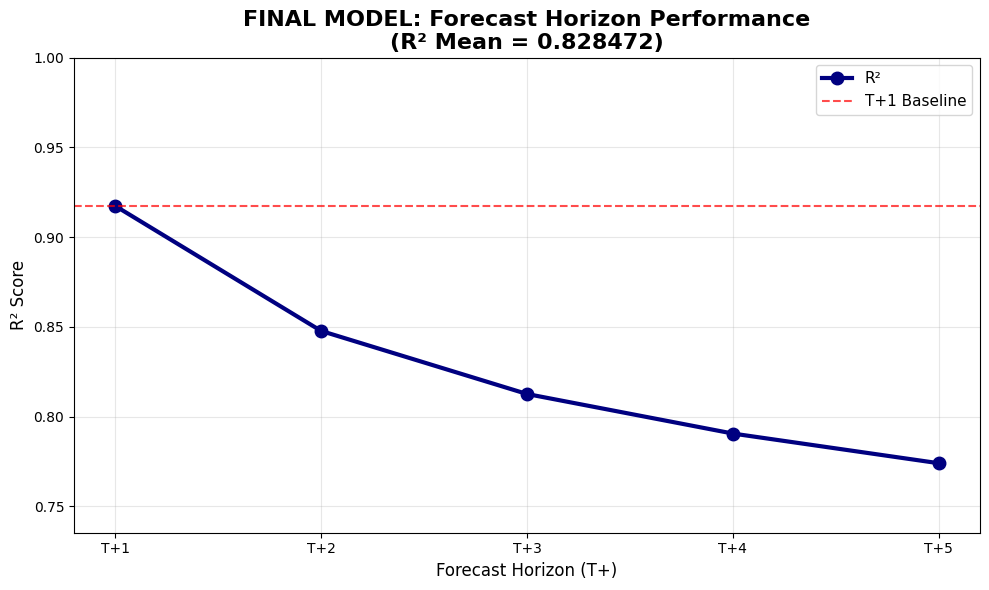

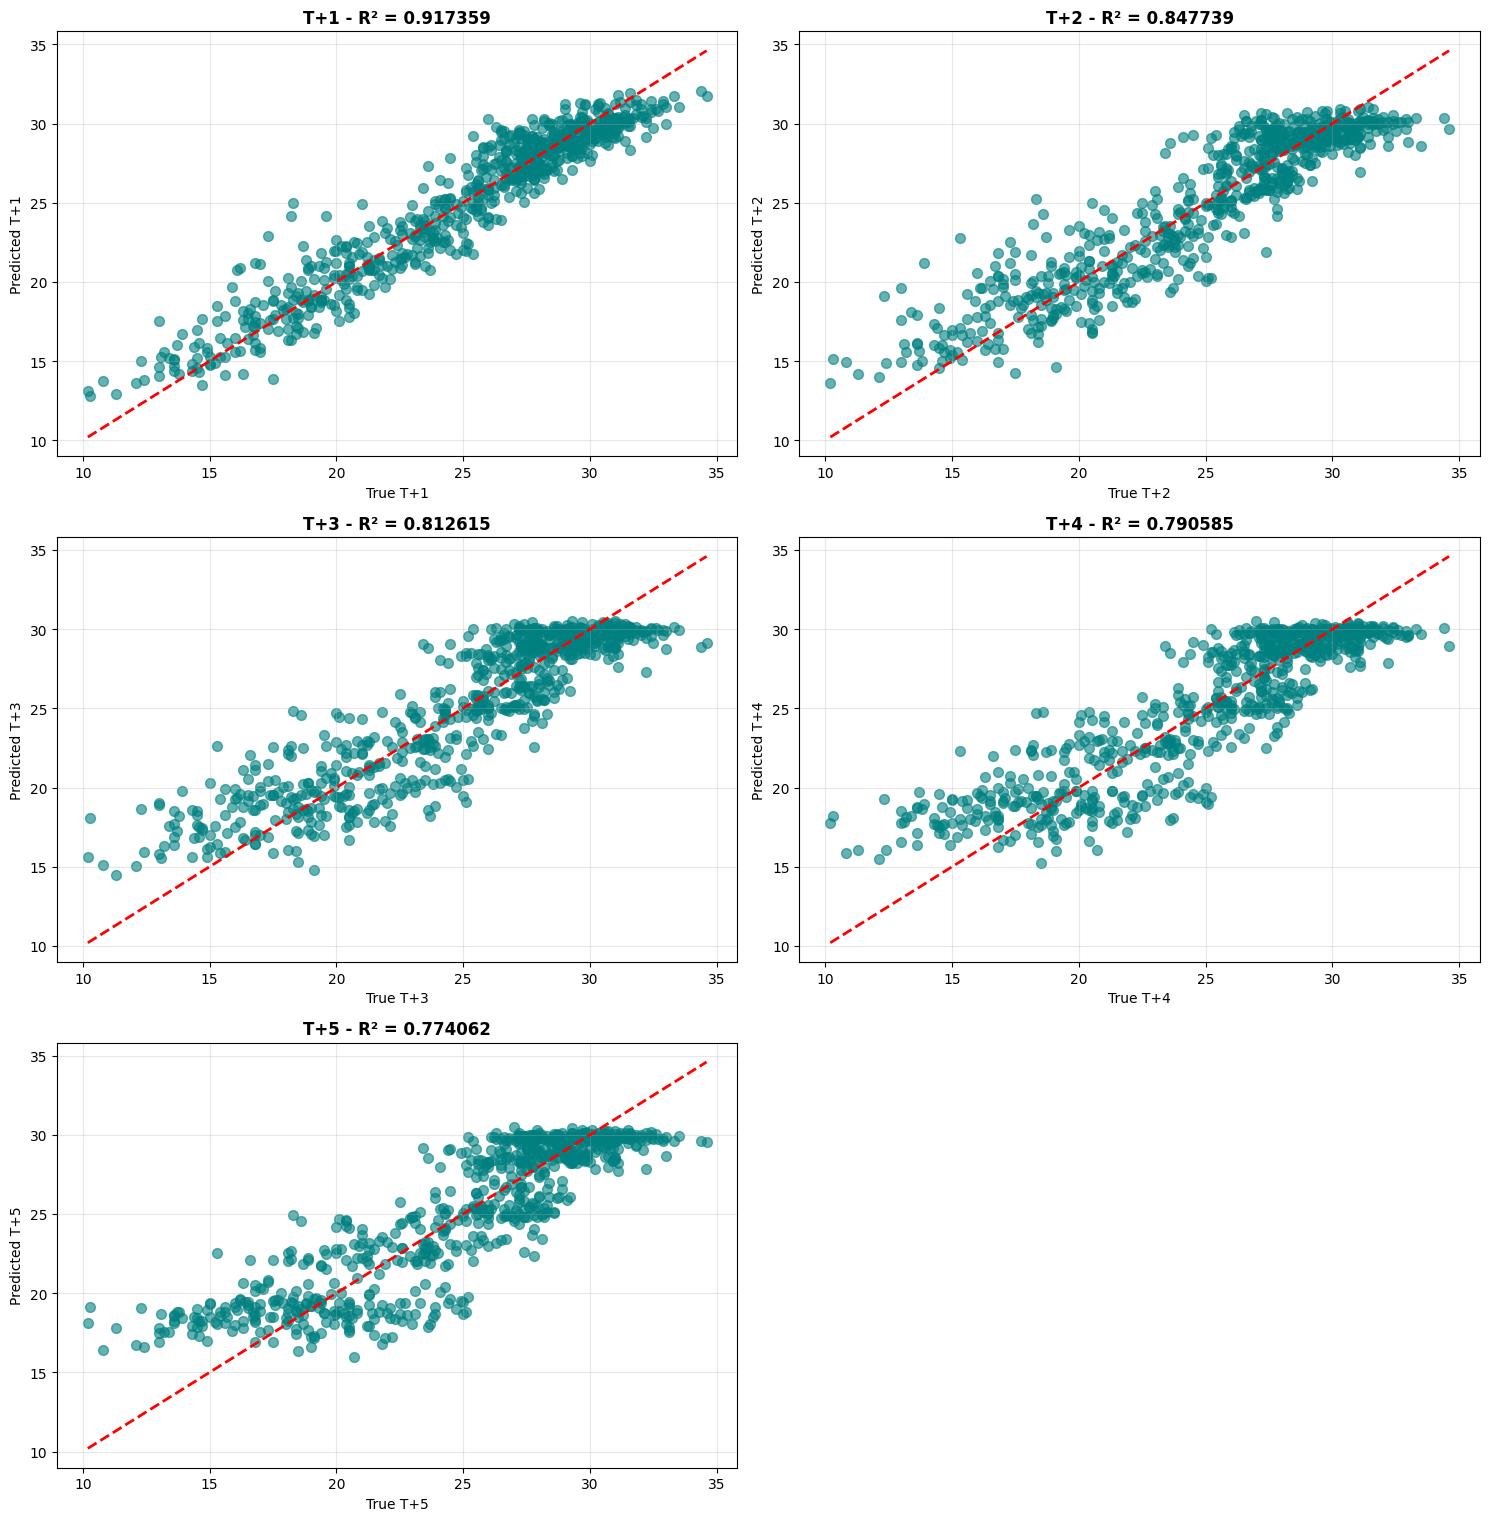

In [17]:
# === LOAD MODEL ĐÃ TUNING ===
result = joblib.load('../models/daily/BEST_CATBOOST_TUNED_DAILY.joblib')
model = result['model']
best_r2 = result['best_r2']
final_r2_mean = result['final_r2_mean']
target_names = list(result['final_r2_per_target'].keys())[::-1]  # T+1 → T+5

print(f"Model đã load thành công!")
print(f"BEST R² (tuning): {best_r2:.6f}")
print(f"FINAL R² (model): {final_r2_mean:.6f}")

# === DỰ BÁO ===
y_pred = model.predict(X_test)

# === Chuẩn bị y_test ===
y_test_df = pd.DataFrame(y_test).copy()
n_targets = y_test_df.shape[1]
y_test_df = y_test_df.iloc[:, ::-1].copy()
y_test_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
target_names = y_test_df.columns.tolist()[::-1]  # T+1 → T+5

print(f"Dự báo thành công: {y_pred.shape}")

# === Tính metrics ===
r2_list = [r2_score(y_test_df.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
mae_list = [mean_absolute_error(y_test_df.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
rmse_list = [np.sqrt(mean_squared_error(y_test_df.iloc[:, i], y_pred[:, i])) for i in range(n_targets)]
r2_mean = np.mean(r2_list)

# === DEGRADATION ===
degradation_list = [r2_list[i] - r2_list[0] for i in range(1, n_targets)]
degradation_1_to_5 = r2_list[-1] - r2_list[0] if n_targets > 1 else 0

# === IN KẾT QUẢ ===
print("\n" + "="*100)
print(f"{' '*35} FINAL MODEL PERFORMANCE")
print("="*100)
print(f"{'Day':<8} {'R²':>10} {'MAE':>12} {'RMSE':>12} {'ΔR² vs T+1':>15} {'% Change':>12}")
print("-" * 100)
for i, (name, r2, mae, rmse) in enumerate(zip(target_names, r2_list, mae_list, rmse_list)):
    delta = "—" if i == 0 else f"{degradation_list[i-1]:+0.4f}"
    pct = "—" if i == 0 else f"{degradation_list[i-1]/r2_list[0]:+0.2%}"
    print(f"{name:<8} {r2:10.6f} {mae:12.4f} {rmse:12.4f} {delta:>15} {pct:>12}")
print("-" * 100)
print(f"{'MEAN':<8} {r2_mean:10.6f}")
print(f"{'BASELINE':<8} {best_r2:10.6f} ← từ tuning")
print(f"{'MATCH':<8} {abs(r2_mean - best_r2) < 1e-6}")
print("="*100)

plt.figure(figsize=(10, 6))
days = list(range(1, n_targets + 1))
plt.plot(days, r2_list, 'o-', color='navy', linewidth=3, markersize=9, label='R²')
plt.axhline(y=r2_list[0], color='red', linestyle='--', alpha=0.7, label='T+1 Baseline')
plt.title(f'FINAL MODEL: Forecast Horizon Performance\n(R² Mean = {r2_mean:.6f})', fontsize=16, fontweight='bold')
plt.xlabel('Forecast Horizon (T+)', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.xticks(days, [f"T+{d}" for d in days])
plt.ylim(min(r2_list)*0.95, 1.0)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5*n_targets))
for i, target in enumerate(target_names):
    plt.subplot(n_targets, 2, i+1)
    plt.scatter(y_test_df.iloc[:, i], y_pred[:, i], alpha=0.6, s=50, color='teal')
    min_val = min(y_test_df.iloc[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test_df.iloc[:, i].max(), y_pred[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel(f'True {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'{target} - R² = {r2_list[i]:.6f}', fontweight='bold')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
